# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline
%reload_ext autoreload
%autoreload


SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

import sklearn.model_selection
from scipy.stats import randint as sp_randint

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import svm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import scipy as sp
from scipy.stats import expon
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

import math

from collections import Counter

In [2]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 

# X_competencia = pd.read_csv("X_competencia.csv", index_col="index")
# y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

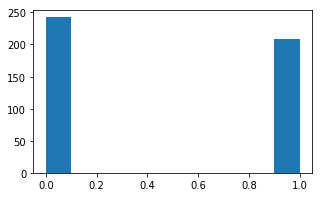

In [3]:
# EJERCICIO 1. 

np.random.seed(1234)


########################################################
## AQUI VA SU CODIGO

X_dev, X_eval, y_dev, y_eval = train_test_split(X, y, test_size = 0.1)

# Objetivo: variables X_dev, X_eval, y_dev e y_eval asignadas
#########################################################


# print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
# print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(5, 3))
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.show()

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8167,0.6556,0.8737,0.6892
2,0.8278,0.6111,0.8878,0.6410
3,0.8222,0.7111,0.8739,0.7523
4,0.8361,0.7111,0.8543,0.7456
5,0.8056,0.7444,0.8822,0.7566


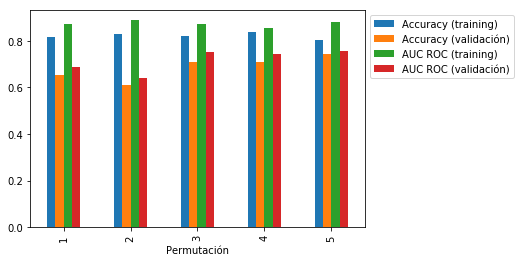

In [4]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

########################################################
def get_scores(train_indexes, test_indexes, decision_tree_criterion="gini", max_depth=3, metrics=[accuracy_score, roc_auc_score]):
    X_train, X_test = X_dev_np[train_indexes], X_dev_np[test_indexes]
    y_train, y_test = y_dev_np[train_indexes], y_dev_np[test_indexes]

    iteration_classifier = tree.DecisionTreeClassifier(max_depth=max_depth, criterion=decision_tree_criterion)
    iteration_classifier.fit(X_train, y_train)
    
    metrics_scores = []
    
    for metric in metrics:
        if metric == accuracy_score:
            y_test_prediction = iteration_classifier.predict(X_test)
            metrics_scores.append(accuracy_score(y_test, y_test_prediction))

            y_train_prediction = iteration_classifier.predict(X_train)
            metrics_scores.append(accuracy_score(y_train, y_train_prediction))
        elif metric == roc_auc_score:
            #Devuelve un array con la probabilidad de la clase 0 y la clase 1.
            #roc_auc_score pide solo la probobabilidad de la clase "positiva", asi que le paso el indice 1
            y_test_proba_prediction = iteration_classifier.predict_proba(X_test)
            metrics_scores.append(roc_auc_score(y_test, y_test_proba_prediction[:, 1]))

            y_train_proba_prediction = iteration_classifier.predict_proba(X_train)
            metrics_scores.append(roc_auc_score(y_train, y_train_proba_prediction[:, 1]))
    
    return metrics_scores
    
#    for metric in metrics:
#        y_prediction = iteration_classifier.predict(X_test)
#        metrics_scores.append(metric(y_test, y_prediction))
        
#        y_prediction = iteration_classifier.predict(X_train)
#        metrics_scores.append(metric(y_train, y_prediction))
    
    
    
#     accuracy_test = accuracy_score(y_test, y_prediction)
#     auc_roc_test = roc_auc_score(y_test, y_prediction)

#     y_prediction = iteration_classifier.predict(X_train)
#     accuracy_train = accuracy_score(y_train, y_prediction)
#     auc_roc_train = roc_auc_score(y_train, y_prediction)

#    return metrics_scores

## AQUI VA SU CODIGO 
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados
# Ejercicio 2.1
classifier = tree.DecisionTreeClassifier(max_depth=3)
classifier = classifier.fit(X_dev_np, y_dev_np)

#classifier.predict_proba([test])

# Ejercicio 2.2


kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_dev_np):
    [accuracy_test, accuracy_train, auc_roc_test, auc_roc_train] = get_scores(train_index, test_index)
    
    accuracies_validation.append(accuracy_test)
    aucs_validation.append(auc_roc_test)
    accuracies_training.append(accuracy_train)
    aucs_training.append(auc_roc_train)
#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training
df["Accuracy (validación)"] = accuracies_validation
df["AUC ROC (training)"] = aucs_training
df["AUC ROC (validación)"] = aucs_validation

display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [5]:
resultados_training = []
resultados_validation = []

########################################################
## AQUI VA SU CODIGO 
## Objetivo: resultados_training y resultados_validation asignadas
#
## Recomendamos seguir el siguiente esquema:
np.random.seed(SEED)

for criterio in ["gini", "entropy"]:
    for altura in [3, 5, None]:
        kf = KFold(n_splits=5)
        auc_roc_test_list, auc_roc_train_list = [], []
        
        for train_index, test_index in kf.split(X_dev_np):
            [auc_roc_test_fold, auc_roc_train_fold] = get_scores(train_index, test_index, decision_tree_criterion=criterio, max_depth = altura, metrics = [roc_auc_score])
            
            auc_roc_test_list.append(auc_roc_test_fold)
            auc_roc_train_list.append(auc_roc_train_fold)
        resultados_training.append( sum(auc_roc_train_list) / len(auc_roc_train_list) )
        resultados_validation.append( sum(auc_roc_test_list) / len(auc_roc_test_list) )
#########################################################

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training # reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation
   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8744,0.7133
1,5,Gini,0.9754,0.6521
2,Inifinito,Gini,1.0000,0.6382
3,3,Ganancia de Información,0.8772,0.7153
4,5,Ganancia de Información,0.9825,0.6967
5,Inifinito,Ganancia de Información,1.0000,0.6873


In [8]:
####################################################################
#Ejercicio extra

# Definición de la clase "Pregunta"
class Pregunta:
    def __init__(self, atributo, valor):
        self.atributo = atributo
        self.valor = valor
    
    def cumple(self, instancia):
        return instancia[self.atributo] <= self.valor
    
    def __repr__(self):
        return "¿Es el valor para {} igual a {}?".format(self.atributo, self.valor)

# Definición de la estructura del árbol. 

class Hoja:
    #  Contiene las cuentas para cada clase (en forma de diccionario)
    #  Por ejemplo, {'Si': 2, 'No': 2}
    def __init__(self, etiquetas):
        self.cuentas = dict(Counter(etiquetas))


class Nodo_De_Decision:
    # Un Nodo de Decisión contiene preguntas y una referencia al sub-árbol izquierdo y al sub-árbol derecho
     
    def __init__(self, pregunta, sub_arbol_izquierdo, sub_arbol_derecho):
        self.pregunta = pregunta
        self.sub_arbol_izquierdo = sub_arbol_izquierdo
        self.sub_arbol_derecho = sub_arbol_derecho    

def construir_arbol(instancias, etiquetas, altura, criterio):
    # ALGORITMO RECURSIVO para construcción de un árbol de decisión binario. 
    # Suponemos que estamos parados en la raiz del árbol y tenemos que decidir cómo construirlo. 
    ganancia, pregunta = encontrar_mejor_atributo_y_corte(instancias, etiquetas, criterio)
    # Criterio de corte: ¿Hay ganancia?
    if ganancia == 0 or (altura != None and altura == 0):
        #  Si no hay ganancia en separar, o llegue a la altura requerida, corto la recursion. 
        return Hoja(etiquetas)
    else: 
        # Si hay ganancia en partir el conjunto en 2
        instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen = partir_segun(pregunta, instancias, etiquetas)
        # partir devuelve instancias y etiquetas que caen en cada rama (izquierda y derecha)

        altura_rec = None if(altura == None) else altura - 1
        # Paso recursivo (consultar con el computador más cercano)
        sub_arbol_izquierdo = construir_arbol(instancias_cumplen, etiquetas_cumplen, altura_rec, criterio)
        sub_arbol_derecho   = construir_arbol(instancias_no_cumplen, etiquetas_no_cumplen, altura_rec, criterio)
        # los pasos anteriores crean todo lo que necesitemos de sub-árbol izquierdo y sub-árbol derecho
        
        # sólo falta conectarlos con un nodo de decisión:
        return Nodo_De_Decision(pregunta, sub_arbol_izquierdo, sub_arbol_derecho)

def encontrar_mejor_atributo_y_corte(instancias, etiquetas, criterio):
    max_ganancia = 0
    mejor_pregunta = None
    for columna in instancias.columns:
        #Generar valores borde
        bordes = generar_valores_borde(instancias, etiquetas, columna)
        print("Atributo: {}, Bordes: {}".format(columna, bordes))
        for valor in bordes:
            # Probando corte para atributo y valor
            pregunta = Pregunta(columna, valor)
            _, etiquetas_rama_izquierda, _, etiquetas_rama_derecha = partir_segun(pregunta, instancias, etiquetas)

            #Ver como refactorizar
            if(criterio == 'gini'):
                ganancia = ganancia_gini(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha)
            else:
                ganancia = ganancia_entropia(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha)
            #print("La ganancia para la pregunta {}, es {}".format(pregunta, ganancia))
            if ganancia > max_ganancia:
                max_ganancia = ganancia
                mejor_pregunta = pregunta
    print("La mejor pregunta es {}, con una ganancia de {}".format(mejor_pregunta, max_ganancia))        
    return max_ganancia, mejor_pregunta

def generar_valores_borde(instancias, etiquetas, columna):
    bordes = []
    valores_y_etiquetas = pd.DataFrame(columns=["valor", "etiqueta"])
    valores_y_etiquetas["valor"] = instancias[columna]
    valores_y_etiquetas["etiqueta"] = etiquetas
    valores_y_etiquetas.sort_values("valor")        
    if not valores_y_etiquetas.empty:
        anterior_etiqueta = valores_y_etiquetas["etiqueta"][0]
        anterior = valores_y_etiquetas["valor"][0]
        for indice, fila in valores_y_etiquetas.iterrows():
            actual = fila["valor"]
            actual_etiqueta = fila["etiqueta"]
            if actual_etiqueta != anterior_etiqueta:
                bordes.append((anterior+actual)/2)
            anterior = actual
            anterior_etiqueta = actual_etiqueta
        #Que pasa si hay 1 solo elemento?
        #Que pasa si son todas las mismas etiquetas?
        if len(bordes) == 0:
            bordes.add(anterior)
    return bordes

def partir_segun(pregunta, instancias, etiquetas):
    # Esta función debe separar instancias y etiquetas según si cada instancia cumple o no con la pregunta (ver método 'cumple')
    # COMPLETAR (recomendamos utilizar máscaras para este punto)
    instancias_cumplen = pd.DataFrame(columns=instancias.columns)
    instancias_no_cumplen = pd.DataFrame(columns=instancias.columns)
     
    columna_etiqueta = pd.DataFrame(data=etiquetas, index=instancias.index, columns=['etiqueta'])
    instancias_con_etiqueta = pd.concat([instancias, columna_etiqueta], axis=1)
    instancias_cumplen_etiqueta = instancias_con_etiqueta.where(pregunta.cumple(instancias_con_etiqueta)).dropna()
    instancias_no_cumplen_etiqueta = instancias_con_etiqueta.mask(pregunta.cumple(instancias_con_etiqueta)).dropna()
    etiquetas_cumplen = instancias_cumplen_etiqueta.loc[:,'etiqueta'].tolist()
    etiquetas_no_cumplen = instancias_no_cumplen_etiqueta.loc[:,'etiqueta'].tolist()
    
    del instancias_cumplen_etiqueta['etiqueta']
    del instancias_no_cumplen_etiqueta['etiqueta']
    
    instancias_cumplen = instancias_cumplen_etiqueta
    instancias_no_cumplen = instancias_no_cumplen_etiqueta
    
    return instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen

#Como hago para refactorizar esto?
def gini(etiquetas):
    diccionario = dict(Counter(etiquetas))
    suma = 0
    for etiqueta in diccionario.keys():
        suma += (diccionario[etiqueta]/len(etiquetas))**2
    impureza = 1 - suma
    return impureza

def ganancia_gini(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha):
    etiquetas = np.concatenate((etiquetas_rama_izquierda, etiquetas_rama_derecha))
    n_izq = len(etiquetas_rama_izquierda)
    n_der = len(etiquetas_rama_derecha)
    n = len(etiquetas)
    
    gini_total = gini(etiquetas)
    gini_izq = gini(etiquetas_rama_izquierda)
    gini_der = gini(etiquetas_rama_derecha)
    
    ganancia_gini = gini_total - ((n_izq/n)*gini_izq + (n_der/n)*gini_der)
    
    return ganancia_gini

def entropia(etiquetas):
    diccionario = dict(Counter(etiquetas))
    entropia = 0
    for etiqueta in diccionario.keys():
        proporcion = diccionario[etiqueta]/len(etiquetas)
        entropia += -proporcion*log(proporcion,2)
    return entropia

def ganancia_entropia(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha):
    etiquetas = np.concatenate((etiquetas_rama_izquierda, etiquetas_rama_derecha))
    n_izq = len(etiquetas_rama_izquierda)
    n_der = len(etiquetas_rama_derecha)
    n = len(etiquetas)
    
    entropia_total = entropia(etiquetas)
    entropia_izq = entropia(etiquetas_rama_izquierda)
    entropia_der = entropia(etiquetas_rama_derecha)
    
    ganancia_entropia = entropia_total - ((n_izq/n)*entropia_izq + (n_der/n)*entropia_der)
    
    return ganancia_gini

def imprimir_arbol(arbol, spacing=""):
    if isinstance(arbol, Hoja):
        print (spacing + "Hoja:", arbol.cuentas)
        return

    print (spacing + str(arbol.pregunta))

    print (spacing + '--> True:')
    imprimir_arbol(arbol.sub_arbol_izquierdo, spacing + "  ")

    print (spacing + '--> False:')
    imprimir_arbol(arbol.sub_arbol_derecho, spacing + "  ")


def predecir(arbol, x_t):
    if isinstance(arbol, Hoja):
        return max(arbol.cuentas, key=arbol.cuentas.get)
    
    if(arbol.pregunta.cumple(x_t)):
        return predecir(arbol.sub_arbol_izquierdo, x_t)
    else:
        return predecir(arbol.sub_arbol_derecho, x_t)

def predecir_proba(arbol, x_t):
    if isinstance(arbol, Hoja):
        #Retorno la probabilidad de que la clase sea 'Si'
        return arbol.cuentas[1]/(arbol.cuentas[1] + arbol.cuentas[0])
    
    if(arbol.pregunta.cumple(x_t)):
        return predecir(arbol.sub_arbol_izquierdo, x_t)
    else:
        return predecir(arbol.sub_arbol_derecho, x_t)
    
class MiClasificadorArbol(): 
    def __init__(self, columnas=None):
        self.arbol = None
        self.columnas = columnas
    
    def fit(self, X_train, y_train, max_depth=None, criterion='gini'):
        self.arbol = construir_arbol(pd.DataFrame(X_train, columns=self.columnas), y_train, max_depth, criterion)
        imprimir_arbol(self.arbol)
        return self
    
    def predict(self, X_test):
        predictions = []
        for x_t in X_test:
            x_t_df = pd.DataFrame([x_t], columns=self.columnas).iloc[0]
            prediction = predecir(self.arbol, x_t_df) 
            #print(x_t, "predicción ->", prediction)
            predictions.append(prediction)
        return predictions
    
    def predict_proba(self, X_test):
        predictions = []
        for x_t in X_test:
            x_t_df = pd.DataFrame([x_t], columns=self.columnas).iloc[0]
            prediction = predecir_proba(self.arbol, x_t_df) 
            #print(x_t, "predicción ->", prediction)
            predictions.append(prediction)
        return predictions
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        
        accuracy = sum(y_i == y_j for (y_i, y_j) in zip(y_pred, y_test)) / len(y_test)
        return accuracy
        
        
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

def get_dt_scores(train_indexes, test_indexes, decision_tree_criterion="gini", max_depth=1):
    X_train, X_test = X_dev_np[train_indexes], X_dev_np[test_indexes]
    y_train, y_test = y_dev_np[train_indexes], y_dev_np[test_indexes]

    iteration_classifier = MiClasificadorArbol()
    iteration_classifier.fit(X_train, y_train, max_depth, decision_tree_criterion)
    
    metrics_scores = []
    
    y_test_prediction = iteration_classifier.predict(X_test)
    metrics_scores.append(accuracy_score(y_test, y_test_prediction))

    y_train_prediction = iteration_classifier.predict(X_train)
    metrics_scores.append(accuracy_score(y_train, y_train_prediction))
    #Nuestro predictor solamente devuelve la probabilidad de la clase positiva
    y_test_proba_prediction = iteration_classifier.predict_proba(X_test)
    metrics_scores.append(roc_auc_score(y_test, y_test_proba_prediction))

    y_train_proba_prediction = iteration_classifier.predict_proba(X_train)
    metrics_scores.append(roc_auc_score(y_train, y_train_proba_prediction))
    
    return metrics_scores

for train_index, test_index in kf.split(X_dev_np):
    [accuracy_test, accuracy_train, auc_roc_test, auc_roc_train] = get_dt_scores(train_index, test_index)
    
    accuracies_validation.append(accuracy_test)
    aucs_validation.append(auc_roc_test)
    accuracies_training.append(accuracy_train)
    aucs_training.append(auc_roc_train)
#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training
df["Accuracy (validación)"] = accuracies_validation
df["AUC ROC (training)"] = aucs_training
df["AUC ROC (validación)"] = aucs_validation

display(HTML("<h3> TABLA 1 EJERCICIO EXTRA </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Atributo: 0, Bordes: [0.6419185757438485, 0.3639483375031929, -0.09094691663060273, 0.03975736904974489, 0.8831192563212493, 0.13643003329610714, 0.3698364011385162, 0.26514860018091496, -0.3624417080182324, 0.5365041703826727, 0.06823013265187586, -0.49523193952364675, 0.0895051320414082, 0.446786608746539, 0.7396819609130211, -0.5734018897913503, -0.08995643516950391, -0.0942732782559396, 0.6728470709039526, 0.7357177030605284, -0.8388746762152772, -0.7373168495950024, -0.39086476023752836, -0.07188552545606203, 0.4280444705287546, -0.03571058515486558, 0.723370381030096, -0.9631399526591358, -0.1301614295368071, 1.5056729766556238, 1.21326863629979, -0.16219858443581603, 0.5710936806905434, -0.1273629344015974, -0.6261846368319783, 0.41931538123988266, -0.29664596625609446, 0.8141482830826747, 0.12438103257487435, -0.30177287000625785, 0.09844267174518492, -1.471762893925134, 0.18518704866217456, 0.03842947312162215, 0.5409803060166316, 1.224547538149912, 0.9976559783610557, -0.1824

Atributo: 3, Bordes: [-0.4014017108439524, -0.906003929601404, -0.8716014778218542, -0.019635616051232097, 0.1932968747955765, -0.03648084131577495, -1.2468898717038799, -1.3837913354373805, -1.4850924572675321, 0.29287821614402515, 0.841264963906044, -0.06246139189054167, -0.8291448453094236, 0.020521812276995288, -0.2793683888837916, -0.5087658376722332, -1.217016463691214, 1.5275881667459115, 1.0680754571060045, 0.04199691680107093, 0.25826042273333727, 1.1361095271508255, 0.613079530554841, 0.7196638526298569, 0.022674074469801353, 0.8553659614707492, -0.039139720929532135, 0.0007495404286740476, 0.8231175514620719, 0.9406803671154185, 0.7071000124185067, 0.4059538161471917, 0.22889042821015057, 0.631067544194466, 0.39973458992978267, -1.2288517445735692, -1.6522456885905537, 0.4306490601444192, 0.8900455507991011, 1.7293529438103472, 0.8647107670612038, -0.39549536067184043, -0.7235339639983295, -0.26282543292513016, -1.223172191592738, -0.6153678782228635, -0.4486586379450904, -1

Atributo: 6, Bordes: [0.8627605336797814, -0.514437323705269, -0.668914434597849, 0.44681097940129866, 1.8541817838410304, 0.11804997281570095, -0.18523231436519244, -0.7558083594381846, -2.330219761593969, -0.283677054388328, -1.3930630581901957, 0.3514940599205568, 0.5405192228041988, -0.27915100529131354, -0.15922425397703444, -0.08806809035222495, 0.4603200757290982, -0.8284673030353961, -0.7699599264001359, 0.012458143216788398, 0.4015473590992078, -0.7760883807640471, -0.304323078039359, -0.6545473734331932, -1.16056623310237, -0.023695528280050712, 0.34554006488971645, 0.15342262136868667, 0.46215883596586416, 0.10505980005352755, 0.2697034172030913, 1.5708326420191925, -0.6155707542561755, 0.31685786797666793, -0.18069616836433045, 0.833682676687759, 0.917648525824444, 0.45628076642493776, 0.9469567842715807, 0.03077039213588567, -0.06063033540379026, -0.5468537795929325, -0.22346986938712765, -0.31637136105452196, -0.038481827397706614, 0.21828088998115297, 0.29809214041948284

Atributo: 9, Bordes: [-0.4950460219198354, 1.2410963981771603, 1.3291333332729944, -0.04691774727798326, -0.7617009409996907, -0.5378413114149594, 0.9585547401443398, 1.0879048678651748, 0.5272467344831587, 0.09158148847790454, 0.11621552510330269, -0.7076971332007049, -1.1079373935857615, -0.42009134966865525, 0.6111921051709515, 0.6497518116233574, 0.427446437753804, 0.6444876009632761, 1.5099123712010631, 0.004795876436625712, -0.04643735843454583, -0.3118412939476579, 0.6825703244709401, -0.2593819181960906, -1.7170261911305325, -0.9966734256728431, -0.8904771739180813, 0.6394024061961985, -0.18287086957028004, -0.9366652736175375, -0.30448639780160247, -1.0073273637931148, -2.1298919294222034, -0.3285593722004243, 0.9549564493611292, -0.051593173103260226, -0.4368328599018344, -0.6921411961395323, -1.1996852257738035, -0.3848647158097186, 0.8652125440968714, 0.8947474429091467, 0.963938225538481, 0.5665236900990529, 1.2705245746215805, -0.2589875248732335, -0.8101634354210047, -0.

Atributo: 12, Bordes: [-0.11418485776765, -1.0974470134345635, -1.1688468820923579, -0.31927849566195976, 0.36245720934772613, 0.3458495801550632, -0.17171667031290744, 0.12538335426518352, -0.7746942071907815, 0.04511712938485013, -0.7323960212084528, -0.13387291403962093, 0.10517088293838106, -0.16637303356490393, 0.7933222032461693, 0.4471402243861543, 0.01923920081809899, 0.09077146969574579, 0.9519015519232668, -1.2025972530974327, -0.9117122393568544, 0.541125043252897, 0.4969518875345603, -0.027590315610508342, -0.303184028147923, -0.3968695030339904, 0.9430392016027644, -1.2306561639310831, -0.15293589530221383, 0.8164227695517777, 0.019435579741948428, -0.079497695325634, -1.2133975165385307, -1.302353980185222, 0.22323232478725485, 1.0323628244466134, 1.1299498297496173, -0.15616718847387778, 0.5505317249811491, -0.2608342824420473, 1.0764841308712612, -0.40362364733179235, -0.7319520870917284, 0.1421913858280891, 0.23144126223318584, 0.6993733999657173, 0.4402818896278589, 0

Atributo: 15, Bordes: [0.6480241543106958, -1.8156449494731135, -1.350583484409574, -1.1254009229761535, 0.0174369349441936, -0.6249991814309103, 0.43179203305442543, 1.1651738283715496, 0.5975133876703896, 0.37399993171381674, -0.04652574236911994, -0.20779679640721238, 0.3624400215959943, -0.5647943331264362, 0.37713549120479084, 0.5186941468969144, -0.25410024372255907, 0.5939378425913704, 0.33107800912415175, -1.0251559220004929, 0.36125302248021357, -0.2010820644570539, -1.181458320395261, -1.4254234614082826, -0.8593189958217031, 0.4363485920806247, 1.5889100005709795, -0.6177765484047862, -0.6748042433946059, -0.45257322775625775, -0.052979134577149756, 1.1107148158210485, -0.7790508170665842, -0.012413337591249157, -0.5356292014631737, -0.12435053293373499, -0.6985544464721336, 0.1253990388067177, -0.6054286068386963, 0.24787856452945028, 0.33990300994029604, 0.4688113388691426, -0.3024113802774288, 0.11112694480711077, 1.3250169308202362, 0.5895531879251097, 0.2722504831551651

Atributo: 18, Bordes: [-0.4488076778487761, 0.7810446785395501, 0.3432248002596424, -0.3267679625867268, -0.3694526448378497, 0.39170725157387665, -0.44196161109556525, -0.6901454446361713, -0.3578348157716095, -0.8363816314111416, 0.7636230461328852, 0.7176305865279246, 0.8104256731923343, -0.6516377922591567, -1.7996497914914857, -0.6503468323227095, 0.2744123402209569, -0.3000261375695439, 0.08211067644717963, 0.19789863255127604, 0.7302724013097457, 0.14481972503683338, -0.06758114201828935, 0.5093329729973612, 0.027423464110363394, -0.5336794742798396, -1.576910019514916, -0.01901625069889612, 0.4123361108185406, 0.15716012364286958, 0.7608071190268151, -0.45512638458128274, 0.074514890574645, -0.9529095871161058, -0.5737722155120164, 1.269555267578854, 1.2057723578819122, -0.8020316050869042, -1.065246176090253, -0.61011134343088, -0.9379876575849113, 0.27791205472332847, 0.46842344323256724, 0.8125202425882284, 0.6022641216296738, 0.31398324494031504, -0.29655274665358855, 0.205

Atributo: 21, Bordes: [-0.31846288248119115, -0.49866876212881156, -0.2044491438670079, 0.8789398836887541, 0.28388170803853396, -0.279423924067121, 0.44364570717912866, -0.4469159867002839, -0.46411019843117884, -0.49416429511521553, 0.7908645713825677, -0.3850743981114885, -1.3763077949146092, -0.3468249290886207, -0.3278450281973687, -0.17642349194330498, 0.320732666194934, 1.0884199533185401, -0.0918637750833626, -0.23194552534900498, -0.28893882205904664, 1.0234072877598281, 0.9922156038212868, -0.034291034239775364, 0.1642278670243375, 0.05701679672247299, 0.5417714230454039, 1.3706167645006195, -0.885054504931482, -0.1204465477843363, 0.23330869240270968, 0.5370598666608645, 0.061711166831171255, -0.639291912679775, -0.7750096374326447, -0.17383319440914033, -0.011990374379473055, 0.0948452782720994, -0.05047187438852835, -0.9602669565223891, -1.569150679777276, 0.2331802151728817, 0.5828208858134051, 1.005567193194809, 0.2730133940979241, 0.6177862395924376, 0.27897643315267484

Atributo: 24, Bordes: [0.43141533126714526, -0.20056730782132615, -1.93639464695229, -0.619371111701399, 0.32376299462992314, -0.10194047923793242, -0.5961566561895504, -0.02866321849737488, 0.7583614881439606, 0.5037566741361698, -0.590940456311986, -1.622879284518398, -0.3790030558871563, -0.029117300044713773, -0.029069673621195335, 0.7703474001951622, 0.8632414089568323, -0.1610228573900647, 0.006643306843462239, 0.39277620068978514, 0.8138667315753267, 1.5245747567259773, 0.8211699570792363, -0.4722301880565152, -1.2040504902901497, -0.6146071042143666, -0.5733660061511752, -0.34083934753306233, -0.4329243012719334, -0.7277092499690778, 0.9149491064432087, 0.4668605700028051, 1.5100044481641377, -0.3639686250863517, 0.36403537643824485, 0.4088012675688806, 1.1373664421432894, 0.15254928184228772, 1.572823669909236, 1.1438066099132447, -0.7513949601025599, -1.4276544682452545, 0.00035007622130811544, 0.6920241335047469, 0.6181478127452482, 0.5780802123011299, 0.7256628611150189, -0

Atributo: 27, Bordes: [0.2598220172295105, -1.1126722654368724, -0.325787166565918, -0.1594633721158125, 0.7566423731762472, -0.20665677862054022, -0.533833579208509, 0.1740224475044508, 0.0826383529384237, 0.8969528123819895, -0.7736738502559206, -1.1231693334896058, -0.11531575297023525, -0.3728599365855282, -0.2640404726321747, 0.2878419910152351, -0.32196899399831325, 0.46000929535135504, 0.35137732523749815, -0.5162887825979569, 0.1905717884952281, 0.08790366017994306, -0.9743099013803154, -1.330290265773418, -0.9052486871380014, -0.11539646482113292, 0.39104705911457177, 0.3529086918733122, 0.6875706679735047, -0.43678644756097695, 0.8193563682447669, 0.9907636882073911, 0.0670935400662443, 0.6518005212436953, -0.6510313050069052, -0.336306038925999, 0.16586391181192783, 0.7104681960852305, 0.37481886544598997, 0.38414048818224644, 0.18988889426314304, 0.16991716154536476, 0.07712607445348099, -0.06689318211140022, 0.5776622001694729, -0.44384831264251945, -0.5648871203026745, -1

Atributo: 30, Bordes: [-0.1280305196660586, 0.9116136327563711, 0.9064589897151822, 0.8921730481211221, 0.38327715691535447, -0.5842384536969663, -1.5835447213655782, 0.6290319697205959, -1.5410441125469567, 0.7694108150953305, 0.3457791320960872, -0.5461884518011562, -0.8779295986487405, 0.00116844451842113, 0.6175048274580791, -0.6887807804647911, -0.39881419602145024, -0.603561873162528, 0.10754681006519776, -0.061333349759797706, 0.3791737316832406, 0.42694634825066563, 1.6805755528693669, 1.2931001651338487, 0.3104861555521408, 1.4200500671333551, 0.535864620428353, -0.40042370566497276, -0.22733624302733174, -0.2742691287609224, -0.9039397410776044, -0.2636912040826894, -1.3459068042796694, -0.8140158574021502, 0.2248488191820328, -0.8524529433563712, -0.015369624665116821, 0.552399887699487, -1.2602414242796414, -1.2124881391321074, 0.04766079032495668, 0.33348727655242427, -0.4068517247413868, -0.6065824075101184, 1.2932247655851303, 1.1117916580520033, 0.40869928684724405, 0.5

Atributo: 33, Bordes: [-0.3741607208263807, 0.5131267809279519, 0.3834863404367663, 1.0310466535596159, 1.3635667948864545, 1.4409397944030078, -0.17873378621640007, 0.33734955514296394, 1.0045311603742242, -0.03552322842092742, 0.05592169964519328, -0.15644131419317808, -0.11761568096781598, 0.3380563830390646, -0.34138552150877577, -0.8891464020877867, -0.30951062976917004, 0.1749144432860588, 0.12278378387936967, 0.8683718720528965, 0.4318704967828327, -0.05569683687551352, 0.2005551935892696, 1.4689702120087111, 0.12824953217331914, -0.4554730094896486, -0.48581675100762933, 0.2777475015715365, -0.21737154174552903, -0.01658536213660708, 0.43149360418819277, -1.5221399219943104, 0.08796179172098732, 0.19504825442317572, -0.42539260621194297, -0.28928567909283504, 1.4994409641958157, -0.9641201820039823, -0.3140080173201879, -0.49022705201977645, -1.1823838031388865, 0.7607628781763357, 0.42897331739097044, 0.02619392730175929, 0.8131540976274707, 0.8150064829777373, -0.252301531307

Atributo: 36, Bordes: [1.470720161341641, -1.0698782095221706, -1.5268872122161667, -0.7057029965953063, -0.34262932238932653, 0.17073939154133488, 1.0396439680274743, -0.280978115105949, -1.5646655981700022, 0.2089551893487956, -0.4057855501724528, -0.4684869001263536, 0.4378675464249736, -0.5318955814672528, -0.06139690643670431, -0.22439721866730727, -0.4537409411536064, 0.44897078872936136, -0.4368137282713658, 0.42671753617586267, -0.43184489103647317, 0.7016222769463818, 0.8605383249572297, -0.9262203045499263, -0.42822077509358875, -1.2651372879584586, -0.7899785979294196, -0.45281097566282646, -1.0203189186610497, -1.1020287154396535, -0.0019518768068463865, 0.5171344185221544, -0.014369688873850595, -0.8248277841667877, 0.12685450216307675, -0.8484919579035954, -0.3891631004547236, 0.266784015628819, 0.5028822107800476, -0.2416511560513154, 0.11774769969414073, 0.6884571659324612, 0.1673781696201344, 0.1622886901361883, -1.1049530541795687, -1.299764230870597, -0.1679865036779

Atributo: 39, Bordes: [-1.0191488914904512, 1.2680044368760712, 0.04002609114157152, -1.1510779350963913, 0.019622388413872788, 0.470573518478678, 0.256336202535091, -0.43060135590153736, 1.2071533956997984, -0.17644648657465478, -0.14966931163303537, -0.22466958027656986, 0.10738918595110686, 0.49526403602219987, 0.3041231761464376, -0.8727121427135927, -1.5744952239703953, -0.004708105368236681, -0.012911459455614172, -0.1368617756926529, 0.813610688327731, 0.9010162268426909, 0.43068072169900656, -0.43202852678644055, -1.0030695601748227, 0.3874765163704593, -0.029414592914900096, 0.9538774898769049, 1.0754467629629498, 0.5681317819888194, 1.2730952497453796, 1.2910259062297302, -0.17524736751147357, 0.03000880501331609, 0.22387220440695346, 0.8296099510972449, 1.0192219831376181, 0.048510263281849264, -0.06415889954046372, -0.019700431740383106, 1.4153284073968055, -0.29646770868933037, -0.5922894602933149, -1.087387107750159, -0.2593446079108186, -0.05596685333304299, 0.9791494121

Atributo: 42, Bordes: [0.14330132036013588, 1.3089009341998552, 0.3755105127685822, -0.35881065918905475, 0.30065057792156413, -0.20705610313228512, -1.4917227644691713, -0.5946801173898353, -0.2644923196316985, -0.7156360241951645, -0.08560319579927889, -1.1862325479472622, -0.1982809480448452, 0.3608381741417944, 0.30667841279852814, 0.13898453718551793, -0.5080715692565316, 0.5670764533511401, -0.2869733527803337, -1.0085862866938327, 1.108190306507645, 0.8083669061885114, 0.8113574193413575, 0.6895608349941814, 0.24014430508428364, -0.16357621083188376, 0.011327163933286089, 0.12964961543518522, -0.6082202016236298, 0.9773787328556616, 0.5583202050177816, 0.4773185440319384, 0.10050435951611902, -1.268371814126265, 0.8357512767925191, -0.38028012445935544, -0.13824346086667272, 0.21601107002816544, -0.63891727862547, -0.5809569685446622, -0.8224330817896113, 0.7422404080302742, 1.6812937883144725, 0.5456715676434646, -0.8690977162824965, -1.302410335166655, -2.5108387093735884, -2.

Atributo: 45, Bordes: [0.7298325245038357, 1.2282805968967723, 2.3263556559687144, 0.14040527451184803, -0.511347608061818, -0.08012614528275458, -0.4521560849382777, 0.43187141908426296, -0.33179814135073304, -0.09882443923645699, -0.039480228433850795, -1.5129852614170864, -1.8772755867892248, -0.006224669561374463, 0.8772358616895686, 0.19273387841474054, 1.1443393225084697, -0.22884803142191956, -0.09939070543059447, -0.6921242094435736, 0.3198502995218757, 0.3604676446513314, 0.6597437734103784, 0.6838881211976365, 0.4841694409685875, -1.2522113489684452, -1.1736689391551784, 0.21099553937177087, 0.7266923658017413, 0.002410007481991605, -0.1935479336384595, 1.0913495380619394, -1.0009891827001605, -0.447090125187775, 0.6256301854327446, 0.5981689044606926, 0.46976186689101834, 0.33536591768626284, 0.5745567977267173, 0.3672322608773587, 0.36773604997436005, 0.2876185805484306, 0.2420852810678403, 0.7716385933202483, -0.33051697037822114, 1.5931544417570858, 0.7463328976717151, -1

Atributo: 48, Bordes: [0.8620444976990465, 0.5837418758022638, 0.20343282662639417, -0.20235061279244582, -0.2755769998235691, -0.08179314838463786, 0.9855197001474156, 0.32795921816582585, -0.7885000252551494, -0.1726964289633221, 0.20949902745527366, -0.6422152548108498, -1.1369113415673957, -0.6318554802085871, -0.7850284034324905, -1.3381322174369046, 0.3685917860487655, 0.11887722346060507, -0.8020632975181352, 0.38996121535557265, -0.4746145382458614, -0.3364287328029446, -0.8951826840858359, -1.076644957435907, -0.4754054672691251, 0.2527565769969044, 0.9410711796897775, 0.5115608202410078, -0.5500916959924115, -0.6732467898862289, -0.5852472497057306, -0.04422969052753101, -0.8208302584930811, 0.1476796515029341, 0.9188186927893669, -0.6647738416778723, 0.3407717049248712, -1.3255946301230521, -1.2013714068284835, 0.12756734531562577, 0.7780932167152863, -0.4829314193048264, 0.28640780781913744, 0.4211264783307086, -1.1028824292755086, 0.10419527931809625, 1.0524528994378677, 0

Atributo: 51, Bordes: [-0.7806819192359317, -0.010200338957026989, -0.5012990256813397, 0.39254413822130196, 0.6151419914811902, 0.39509622076514195, 0.43827620388845734, 0.2292249237660337, 1.1122076596432318, -0.07153163025800244, -0.8709422010032306, -0.6037402120656449, -0.307509244701027, 0.7511202624041555, 0.6970615906393768, 0.014739673775335936, 0.039300263909225266, 0.3445294614432258, 0.07078292829645776, 0.4375050092073821, -0.025240508318736476, 0.23925957648185328, -0.5626910589372419, -0.49694808955985476, 0.33817755586879067, 0.11458617205024177, -0.19010868143083906, -0.2593756165282337, -0.8281252822794326, -0.03988947671663515, -0.5824845156765035, -0.09027919089063771, -1.6325274925309887, -1.647994955989215, -0.7106411535244849, 0.8115345068389463, -0.3268833142408619, 0.2738440709681693, -0.8197591081024507, -0.5763004072898787, -0.9757896636596957, -0.38548395147476855, 0.743379253498325, 0.2695548208852064, 0.6599794078517854, -0.13883603932785624, 0.64386833160

Atributo: 54, Bordes: [0.2309165055752021, 0.19018790524564633, 0.2682234530832888, -0.6399821292189753, -0.5494435973721956, -0.4330424540180744, -0.40568000138098864, -0.3971959635377895, -1.9202518162104, 0.15550716316031055, 0.09909175142557565, 0.5264353873832817, -0.32502700201256374, 0.012018039138053799, -0.0082599408055909, -0.2420547165767007, -1.2505583579407922, 1.3009083071704817, 1.2892454396080943, -0.6364153262157686, 0.42817092689235137, -0.01718866907829636, 0.10185797403589175, -0.344782571569465, 0.37459521552821806, -0.13790239715193525, -0.6737882398623314, -0.12622718694790747, 0.255779342673639, -0.8812761099872815, -0.18495731135822746, -0.13102980569142045, 0.4556663578432474, -0.39304665979070674, 0.030661775451428674, 0.5410587009268595, -0.17981351503320003, 0.7091299313062358, 0.4932544680645355, 0.8442206487982638, 0.22416775001375022, -0.4051879038212878, -0.5111035309393416, 0.1135210815625462, 0.6763139808428513, 0.3255939873661653, 0.19438430385401695

Atributo: 57, Bordes: [-0.2501738898531316, -0.46758655613913525, 0.4214524933916163, 0.972917718715345, 0.866565536131386, -0.09102133109347754, -0.9793338872457444, 1.066885216922004, 1.0916020456054887, -0.8606766174093161, -0.2817029578193554, 0.02335062415641223, 0.16362168800987936, 0.3515898405394273, -0.04061348648321677, 0.08778928183039827, 0.4595050245081131, -0.07324967988838682, 0.16918854857467358, 1.3463116105875854, 0.9270823638391581, 1.5414582442928975, 0.8579312596273212, 0.9790720807006086, -0.20043967024182513, -0.2828863545722611, -1.1704541466658385, -0.2042800334373901, -1.0820776117652962, -0.16017942280457337, 0.01962050181497632, 0.4923232277413524, 1.0806956899305913, 0.01231379734375515, -0.5271952109533253, 0.8557904334235481, 0.7057172518500804, -0.5913845016258084, -0.15887291090522673, 0.26040774170862613, -1.0166643375775324, -0.7684444117559728, -0.22507919998118944, -0.08659855799301061, -0.6674838770662446, -0.5387243842499398, -0.28385872149105984,

Atributo: 60, Bordes: [0.8549878784950551, -0.33642902360324134, -0.34833535450566977, -0.2844350421669123, 0.10248422719370627, 0.3290109268017675, -0.5201213837542684, 1.0768691694307284, 0.13722197095885857, 1.234037388240521, -1.4763426765461112, -1.3425832781860663, 0.4916093735037955, 0.6467085170907795, -0.5394871520002467, -2.1318221813065694, -1.3257481621489542, 0.14688463432348559, 0.14144517867120332, -1.4311948804637762, -0.0401162622915166, -0.7720924749547053, 0.23244459315657495, 0.6793560594900928, 0.06870714115914986, -0.6698101800220436, -0.17403279609513295, -0.15408813095229645, 0.10048801626083312, 0.13944945130350336, -0.026840236057230432, -0.14156798061646525, 0.2848255483598685, -1.2581578803688023, -1.790249848696778, -0.5143578079230451, -0.2957648827543408, -0.05394042737739424, -0.34983739424429616, 0.2420456724593821, 0.2691380544412813, -0.8309304194402816, -0.9307862698225271, -0.49707562576914854, -0.7521780572443697, -0.4135014855903945, -0.5522929626

Atributo: 63, Bordes: [0.3158511223434984, 0.2654823069911153, 0.6123757195044837, 0.33698711231805917, 0.508728016095262, 1.5092406940357692, 1.2118412305514172, -0.0723119294925231, -0.503494712126028, 0.8322430297725043, -0.14342255208260313, -0.007063043322880325, -0.1827965121081695, -0.4145273626415344, 0.3662263636901339, 0.9266395047583569, 1.1007274338950925, -0.24145901011260051, -1.257368401669749, 0.39605389994094575, -0.6185571707052174, -0.17993599024667478, 0.24802614290091002, 0.6864387461667167, 0.006198162963025641, 0.4350344026571849, 0.7359002363036012, 0.3468268165170282, -0.27388836851764237, 0.05978599104381732, -0.10437955413486955, 0.45204937600364026, -0.06139100296896248, -0.4156800999272688, -0.33996838620959513, 1.2677873935905972, 1.3460563950731435, 0.14432505427746325, 0.10445612809528396, 0.46749166307109646, 0.29817061802690703, -0.967777353013898, -1.019238577995736, -0.3677221192635295, 0.2542406371161532, 0.6172540520510752, 1.019831811034968, 0.320

Atributo: 66, Bordes: [-1.239135024157975, -0.06071752149117832, -0.7001591178371332, -0.06911942843949603, 0.4006636383472358, 1.233940789542023, 0.24576752263714569, 0.5626372067034864, -0.2959433305344533, -0.9157161638272742, 0.2753773074689791, -0.8167560844900784, -0.25355091747762926, 0.6403460579205705, 0.49399509924555896, 0.44916504747667824, 0.16093989016114282, 0.4301167202657119, 0.26994364287334344, 0.522776551441193, 1.419172627050782, 1.3679316298340258, 0.3810979818183052, -0.014939468710450071, 0.4585564470777661, -0.08548562580088215, 1.8113931383067217, -1.2163991246885006, -1.2688887827627062, 0.7428202874732266, -0.7221933151817165, -0.21477989412076504, -0.5938365077033992, -0.9539378264864694, -0.9164973647452526, -1.4437627360556486, -0.8473965812955566, 0.42466226094159293, 0.4823103130374274, 0.8275767831826122, 1.229906361701444, 0.0885366667109971, 0.7954998760616945, 0.24305327154983764, 0.7727926139669468, 0.3678442864441833, -1.3658292430251908, -0.55947

Atributo: 69, Bordes: [0.4721479791990091, 0.05264027707258276, -0.17465172874107937, 0.5541678516682401, 0.7677243452996376, 0.8145085180706686, -0.4752193425288774, 0.8211111532534756, 0.45965492303313193, -0.14122379145322994, 0.13712162362614166, 0.058437917677635454, 0.24490109410300914, -1.2603088383751206, -0.05271917641473889, 0.37585695113307926, 0.02846266891392174, -1.093124784492363, -1.149262211195352, 0.46357660954421975, -0.22578596316551564, 0.09689742593610534, 0.4121534154042453, -0.16772037012757068, -0.3347414579981432, 0.6373400918653207, -0.18640356233208347, 0.6330554482849681, 0.7856402139501577, 0.457905735724913, 0.872524718329362, -0.49862688883984824, 0.5919674632233127, 1.0701945888107194, 0.34199808592214376, -0.386438616032692, -1.0150578969154607, -0.7790297868518554, 0.17716827560201565, 0.8292634081329726, 0.7696830292587366, -0.40836467599225823, 0.17025191023931388, 0.01847247676792957, -0.7080733237060055, -0.01665324924084799, 0.7560248651191142, 0

Atributo: 72, Bordes: [-0.1554242536482777, -0.48364304391018853, -0.8459323741819806, 0.4449761283261273, 0.017625805267696304, 0.411940550472766, 1.012153148166122, -0.04474664172057158, -0.04953492916503249, -0.15202734215532046, 0.7636842314671783, -0.4346837512417401, 0.6459839751517708, 0.39311589042174766, 0.3290994325629432, 0.28024411587041725, 0.5017504722412092, 1.1812809096371897, -0.7414041197747777, 0.11994064024398306, 0.3999379163767967, -0.12895396803432396, -0.2071956595704188, 0.5287563470030401, 0.7755807437967376, 0.5864494636261942, -0.4050636394632172, -1.064943339065618, -0.4635292797247709, -0.33673485901134825, 0.4396537407820785, 1.1065134995005652, 0.053302692426542425, -0.020003018514963174, -0.12198592894053711, -0.5062518436988717, -0.37819904820596234, -0.5536637329128372, 0.07303659215011443, -0.11464631964724067, -0.11444390203600485, -0.23183628800281114, 1.0608056121248224, -0.378326905790372, -0.6772465679232738, 0.19347528534168693, -0.277338559614

Atributo: 75, Bordes: [-0.010960046358160003, -0.6961690999238441, -0.8007631922078804, 0.40929863554913753, 0.23733277626779953, 0.8002641215991525, -1.8778040778267941, 0.13320639008994595, 1.6380073633783154, 0.13051363761036133, 0.22569487189134615, 0.2582874120334442, -0.8338648593910388, 0.6146305804675504, 0.695260375019825, 0.3569730666831924, 0.049260484467328086, 0.4411754096958623, 0.6826166758660981, -0.40854719419892804, -0.6471462929982388, -0.9097019515742667, -1.5633604335560576, -0.9853744880021461, -0.4447152196334627, 1.0077187379574517, 0.9593951762118128, -0.22868780596578184, -0.8989435094121248, 0.10082780454811047, 0.5625215136745332, 0.7173443596596847, -0.3939208484585427, -0.0632493665740233, -0.4821501683578058, 0.6433222520428207, 0.7340299310908235, 0.32304607574263455, 0.6340311523682469, 0.7202681487348371, -0.4555156635147681, 0.36327379248840064, 0.6113139775978986, 0.9690932144503754, -0.4627661935201946, -0.7388835254457932, -0.9840266086817673, -0.2

Atributo: 78, Bordes: [-0.6768916133656487, 0.3548334242875716, -0.4199721369057289, -0.8702780428198693, -0.31527758089885716, -0.12751519005687545, 0.2288172002945039, 0.16994281806850892, -0.14435719060620406, 0.026472787348172738, 0.9700491669976836, 0.3282103000106463, 0.16592504715978876, -0.8253190939354654, 0.19794871899236427, 0.14368266198133334, 0.42280728661502, 0.19851776672356777, 0.19038851369708631, -0.051985396862089917, 0.2588857727702953, -0.301404838273554, 0.8244258720568738, 1.0298310792072645, 0.15241448139295788, 0.21926087743352046, -1.5349548872196535, -0.6810973521445084, -0.29000123996453087, 0.4905492923429762, 0.30078328081506045, -0.14636617507204489, 1.4132682881224596, 1.1337665969178043, 0.4696344486169292, -0.19872690393525216, -1.4158099183426698, -0.6198917982493263, -1.9291729308032264, -1.375717718213612, -0.6984053704767095, 0.5873331089997187, 0.4839260577968587, 0.10650028770979798, -0.9990611084596401, -0.6878539978187823, -0.7733105929182457,

Atributo: 81, Bordes: [0.4269586845909132, -0.6042415111072817, -1.3357537753675974, -0.6905023645184052, -0.02671724033528, -1.2923821782114675, 0.08932027055663783, 0.41922661915927817, 0.19099189532921698, 1.3083998743768046, 0.37860443418447404, 0.24263343899757572, -0.19898439514153132, -1.3655069788407104, 0.18050646709696716, 1.4369995353446927, 0.28700069292986263, 0.7001370798664844, 0.42488224340367997, -0.32498360218315425, -0.6592734205576013, 0.10360428502931157, -1.252235570514941, -1.6764434414533742, -0.9149892275879175, 0.8335311784808721, 1.5111338501051077, 0.3216165761797811, 0.44152732250907956, -0.5539373192572434, 0.29344028991464705, 1.1436306446773923, -0.8429210833340735, -0.507645357481872, -0.5794735191040299, -0.4588508282243675, 0.09000846746910796, 0.3186863737724911, 0.3574695071815239, 0.3744719901346212, 0.10462658018677162, -0.1827385530187893, -0.006294605475274689, 0.07228611729742979, 0.04073237816681852, -1.397297297594072, -0.3770116746145742, -0

Atributo: 84, Bordes: [-0.0853201020876698, -1.6861835360486879, -1.407920968365881, -0.9149172253952683, -0.14683010620451176, -0.5233029937783772, -0.18957082344198808, 0.04111075815484255, 0.6273314860572872, 0.3278621486770378, 0.08801205147871483, -0.47156371744085424, -0.5626377705872833, -0.24715394723312317, -0.21923172269484145, 0.05978389890409744, -0.2222006659241051, 0.33562136147907495, 0.22666543148781326, -0.11987336248642133, -0.1868250189448757, -0.5358591111287413, -1.693573747359653, -1.974875858611382, -0.8861691750533669, 0.20337462551804397, 1.3116009205931727, -0.6597022962073242, -0.6287054348953178, 0.02808398139289013, 0.2528862522950819, 0.5561310511206369, -0.8295643925135403, -0.8516090841240294, -0.7223231719358595, -0.9571970342648235, -0.638701757013457, 0.8478554247578916, 0.5836448494482613, 0.8793576954351555, 0.7492473272984924, -0.39751783094603477, -0.38182219835559866, -0.49896190745138275, 0.8230349048036586, -0.13684996269908478, -0.861414911899

Atributo: 87, Bordes: [1.4844518705634604, 0.4549996729624375, 0.6393325491570214, 1.1094576351708756, 0.31916326717943333, -0.6923463465518929, 0.05704618508861553, -0.804613841608371, -0.9378640950115299, 0.9252061141270059, -0.26762426241683723, -0.8864724221337255, -0.9226467256618314, -0.15524893231717, 0.6960923667776431, 0.3421959902911545, -0.9088563294821799, -0.15837462393448598, -0.6003101026716567, 0.9079659704464268, 0.012169701230593244, 0.24165376930473575, 0.3814651692370761, -0.5079268144455251, 0.31643992337433835, 0.2735369755018083, 0.7236741083957927, 0.04463534126755862, 0.2897208068988034, -0.6316484023119369, -0.08923419547992949, -0.11377966060775112, 0.03328744513189408, 0.25630020883519056, 1.1511942555686303, 0.6603054837417877, 0.06790529732409928, 0.29478474374379227, 1.0605367055568298, 0.7213499824834564, 0.7328986243457202, -0.9254171489072525, -0.3873441893343869, 0.38253702441042703, -0.11465216204090255, -0.36441493868643426, -1.0576307109063594, -0.

Atributo: 90, Bordes: [-0.8427320434988288, 0.37294804648525587, 0.7667793926130683, 0.8491668234492121, 0.888976827391392, 0.7174348457739329, 0.4988669332385861, -1.5120690193259292, -0.587997586217018, 0.5494930018594628, -1.032474438581539, -0.6437710289007916, -0.43835458719396414, 0.2798746717052053, 0.20309830619677524, -0.1163900777163715, 0.780328266262622, 0.39346093661157255, 0.12502044961999903, 1.2074159510162015, -1.1757666525390973, -0.04113444261803867, -0.4034780730592489, -1.0421462202390905, -0.13350519654087922, -0.6184322983319487, -0.5107785074552404, 0.35616915290672013, 0.507775930518253, -0.24912769668967497, -0.793205539405709, -0.5693807319342061, -0.29775558873160635, -0.7630306604505054, 0.08936214061851333, 1.1780797285542843, 0.2885081391914961, 0.6831068148268673, 0.6150943094790278, 0.28198813521670574, 0.16383626563103307, -0.7229269664571105, 0.7618430655499137, 0.23512049487163805, -0.5834290452269236, 0.5232440126806035, 1.0856850676045409, 0.015093

Atributo: 93, Bordes: [-0.4872857266460907, -0.09219405293677946, 0.8862769696520301, 0.36098954176096887, -0.9550218595284173, -0.8108231151825543, 0.6436484378617343, 0.38606893464442615, 0.20025154408966805, 0.419954841532586, -0.7271637410853296, -0.664502331274329, 1.177327008041375, -0.7469840404418995, -1.7788992907723162, -1.3421288423976276, -1.0687966022210906, 0.3280583317969568, 0.4010723159804607, -0.18320787286647036, 0.0370433151523346, -0.43870572723596796, -0.2748418350184282, -0.5286577510034214, -0.5083710498504435, 0.2949608408892084, 0.6736712520277388, 0.3382216672541405, 0.8034967492771008, 0.7303603311480753, 1.3784784338231324, 0.7780991834045605, 0.28388952330071193, -0.44465291660977957, -0.4427924064963141, 0.3145542481728835, -0.37721495845734865, -0.1592790545546165, -0.5012676642961746, -0.5400143952045114, -0.07429161135764722, 1.1419335378991455, 0.9154466152154688, 0.09859267355303167, -0.6789154945642051, 0.5186346131359584, 0.7913354873238323, -0.223

Atributo: 96, Bordes: [0.31787841695134417, -0.5898970218988083, -0.43978903536659064, -0.9831146375193408, -0.5653267107021912, -0.8715661492279265, -0.032447790948071514, -0.3351754887832118, 0.21002058353498868, 0.49955663817796275, 0.4218634955013929, 0.23340871224732762, -0.42391521595455217, 0.05205826659596463, -0.1439465533482256, 0.23172747446685843, -0.0005385431589615963, -0.21525819223041154, 0.8369408478631861, -0.14188375833004319, 0.10897304269618402, 0.1419615202619826, -0.9188511782955937, -1.6270969239292503, -0.5589315616863286, 0.4407144481731441, 1.482113252568987, -0.002596784220364204, 0.13410531610709348, -0.09562787315395398, 0.15611020084583982, 1.48426956664693, -1.1691280083076556, -0.45331325628419816, -0.5244010249220604, 0.17099403643056166, -0.2793645533650734, 0.3430833951888421, 0.42779185902148165, 0.8076713334440389, 0.5186647055859417, -0.0804121445852024, 0.15828489004834878, 0.17957920991398474, 0.7194118543144293, 0.20827939326732373, -0.11718856

Atributo: 99, Bordes: [-0.29053349715064253, -1.064134610112936, -0.33024758650399977, -0.19197443209496745, -0.7376625215717003, -0.03680500870757242, -0.4621357187566487, -0.7703481717381762, -0.10246811444308732, -0.6028848753055529, 1.0133166803994353, 0.8748709497093525, 0.1688843168950482, 0.016495680855753037, 0.041978402169277285, 0.9295372665779922, 0.654425954325, -1.4016408680502526, 0.0408663185907891, -0.353772896781029, 0.3150749125522413, 0.25914434395323316, 0.7037366969730068, 0.5988176354358736, 0.30813329238504583, -1.0698136768890794, -0.2340217596095749, -0.31501062481841563, 0.5689757840967011, 1.0119033404468074, -1.2812472102413313, 0.21072047952753598, 0.9926294102665034, 1.1521553593161609, 0.7894301240672107, 0.17340277930690876, -0.5182017028795309, -0.1348841010924634, 0.4461817380735258, 0.2500910553644748, -0.33693872112900936, -0.6785095814436501, -0.04531128149398311, -0.7653606362579302, 0.7718446357601308, 0.018302472490491772, -0.6252818475549567, 0.

Atributo: 102, Bordes: [0.09121125119076579, -0.49618639756660887, -0.8834293578188492, -1.026190912594869, -0.5132342193607218, -1.1935683963587782, -0.22290200320875309, -0.04745324712803444, -0.3192571527301203, 0.3082641534627039, 0.2651208284815811, 0.024901828798121087, -0.7036191171165442, -0.7148948121392085, -0.46594981385935014, 0.2807044256474216, 0.21475115174646106, 0.5468190022806152, 0.21648749428389413, -0.47559107369493236, -0.45410198679619307, -0.3717715940168873, -1.4459074490951571, -0.5749768445749193, -0.015844965182942428, -0.15135373610024527, 1.612322958511369, 0.35884570494676427, -0.4571731342542927, -0.8165695472639446, 0.4890764604800617, 1.1708201558993485, -1.0150285888497077, -0.12404300022926712, 0.06792017700645689, -0.46188872069566356, -0.27188686846613375, 1.255428031621546, 0.8964383443553244, 0.7440081874337288, 0.6037621022159947, -0.7291806894874551, -0.6606778335933291, -0.4225246178394303, 0.48978923377215444, -0.04335753758890404, 0.44257612

Atributo: 105, Bordes: [1.0396803173100566, -0.39156364294984136, 0.4192147865088772, 0.2549796315844078, -0.1398379102456287, -0.49319567776916395, 0.8134110993876702, 0.14200263756448414, 0.007231900127184998, 0.43749240215654783, -0.22455699634656193, -0.4166245596321247, 0.01445753385094899, 0.06289177869061213, 0.6436456896388605, -0.08282610696363668, -1.1075084733300828, 0.001136285055716453, -0.512088264140065, 0.21064884918269533, -0.4631442365668298, 1.19115107426576, 0.845246156132619, -0.22658627097200923, -0.6221204737494685, -0.16246785918218426, -0.5675586614681616, -0.11947029227100905, -0.3460672322589824, -0.7140727142508579, 0.0279282896917481, 0.2007697548908668, -0.417361035464655, 0.18123542928852354, 1.3456725556173676, 0.2932687345136224, 0.7113272402935722, -0.665217435785967, 0.28442288145158523, 1.246173332252321, -0.0017480657862562476, 0.02490541198859242, -0.15820854068654117, 0.4765608888397476, -1.181910422320866, -1.7188798504641762, 0.13021194596519814

Atributo: 108, Bordes: [-0.8223691512129208, 2.0206755796961935, 0.028733566442736835, -0.5471745618294074, -0.08256591258904794, -0.26078616778098623, 0.3411663067551194, -1.0183917164771628, -1.5955148890389899, 0.3900179142481466, -0.7963282013780753, -0.8464300431036259, 0.12580845354046966, 0.7529348538819496, 0.09490812042723078, 0.07766296069841844, -0.08876113844759509, -1.1983565151713254, -1.4222066039735473, -0.46674640952878427, 0.37928100404206644, 0.18912830334326525, 0.9392612485703142, 0.06024063854573186, -0.5285757101971983, 0.6399650727377317, 0.2328960054656724, 0.896663973266376, 0.49104792681162635, -1.3573842714322795, -0.10302193131258339, 0.9861474344327003, -0.0325984436524277, -0.810024101989719, -0.42525210134800406, 0.3681346212637587, 0.9036318170707706, -1.0631005652018777, -0.9231923374061141, 0.29325233124503625, 0.6514022614957948, 0.472761185925823, -0.1963895941895355, -0.07681336830818798, 0.6202052054964491, 0.6974143408414902, 0.618432533684461, 2

Atributo: 111, Bordes: [0.08502931235628469, -0.35818097875917965, 0.010780035091277895, -0.01786863879783951, -0.597781149686433, -0.4549028790920028, 0.8206787249408727, -0.3594792302843601, -0.11242561735098217, 0.6623651086108654, -1.2482529332844674, -0.21021703303970907, 0.7505273809445756, 1.1374414124622012, -0.21703633998253447, -0.5354295565952716, -0.8784922870156564, 0.44977445863926374, -0.13394835456798637, -1.0881205667605183, 0.5868241700140352, 1.5755367818767487, 0.1692133433130576, -0.9508710338801974, 0.5171359727948849, -0.06843793091940376, -1.1585217409028146, -0.3819751284087288, 0.23932026417703225, 1.0680873519426015, -0.12016087974098644, -0.17902818884948773, 0.17623100353341456, -0.5197592332983804, -0.44912916295219746, 0.5271193165407884, 0.6442925892594803, -0.7824555819638168, -0.23587743095998853, -0.4774008512989972, -0.8413061332248165, 0.9105756982486746, 0.5894396052364319, 0.4629712515641525, -0.04263823263062003, -0.11301699216652847, -0.30886774

Atributo: 114, Bordes: [-0.8816860599980814, -0.014727416391836584, -1.3963279160501572, -0.7022537963558002, 0.1491303174572522, -0.6028192444732103, -0.01917212317170071, -2.2209945035914958, -0.4400202004051764, -0.27980700610629683, 0.2822187557689595, -0.19150039752082612, -0.31166779127840893, -0.3604621499222984, -0.5765137054326859, -1.1726466824157127, -1.1389837385383252, 0.5336589841543962, 0.08810320588133985, -0.06298098814595271, -0.03972238656277749, 0.23049251789605507, 0.8900607808043494, 0.27048275630651253, -0.051890409420514566, 0.8950339990589786, 0.6999586969636872, 1.144254724390652, 1.3351416806163816, 0.683418654790307, 0.2598086384633126, 0.289636788830004, 0.5750183483121643, 0.015530238913346817, -0.1350518041318065, -0.25487245899979144, 0.45000935504794376, -0.40579140936077096, 1.0705483593036211, 0.3587534890696983, 0.18808379158850194, -0.9992183326751699, -0.08967194986714269, 0.3591519753996481, 0.20522392720485583, -0.09068168874001525, -0.5729550573

Atributo: 117, Bordes: [0.08129674660899933, 0.16252126156529284, -0.3832340512470409, -0.3753990145059441, -0.6845644615420736, 0.7486855091681139, -0.7658920051460096, -0.08523561585334627, 0.3234697031408622, -0.17175888389840627, -0.1393192048715075, 2.242559038070257, 1.298195547257635, -0.06464132823881397, 0.6644389168234968, 1.4038795805001052, 0.326464721471116, -0.13683503597404856, 0.32923033905669274, -0.2534629417166173, 1.7934846338451467, 1.5287556634847623, -0.018933723940856018, -0.3089512473035518, 1.3602521032941755, -0.44476860411311425, -0.9347848349848883, 0.4573340180137784, -0.22298856181898566, 0.054753227145748096, 1.090425221471338, -0.527194497896893, 0.21458982785530376, 0.1330626235179809, -0.07787968932128295, 0.11003773193490746, 0.22316278571292658, 0.7242670810310454, 1.169059750429379, 1.556868372149773, 0.2501267145916644, 0.21049669345185787, 0.19349282105602855, -0.7316692546944719, -0.14459538805368166, 0.499800632857348, 0.2090378310844327, 0.692

Atributo: 120, Bordes: [1.4226136521474364, -0.671101506314458, -0.16733068669668777, -0.5899548370276855, -1.3191613658308379, -0.2679832356054148, 1.1671495610261553, -0.2678817710524952, -0.6625264513153343, -0.31877245197707177, 0.511717371557656, 1.4128995671727236, 1.1636067330594069, -0.1018593644990082, -0.08009509498744935, 0.20373218176949418, 0.4675194123894514, -0.7036787976124395, -0.08859466861590959, 0.5456283579993108, -1.2993742538104043, -0.950182003346408, -0.8228622691585443, -0.6312592783968229, -0.41872352826312054, -0.12944001998310514, 0.3689065744123241, -0.23419484175508615, 0.7687806752579801, 0.9052945847002208, 0.026362025693084545, -0.17918229994540272, 0.2960709386986502, 0.5787176496654131, 0.34784603943844594, -0.12928714805718383, -0.4019876097094828, -0.433174450391998, 0.7964027878653039, 0.916089393842226, 0.1667111586070507, -0.2759400721173909, 0.10033696230711767, 0.25702959029970324, 0.05644047589156506, -0.8285454650849625, -1.2375904967434912,

Atributo: 123, Bordes: [0.42486161098337527, 0.7899198727254232, -0.40841808163099624, -1.274511634655466, -0.598754131440707, 0.47786047301397583, -0.022548144951270943, -0.9468895422331208, -0.4798670017837723, -0.9975672004751199, 0.9816140952705603, 0.8707008686929733, 0.3429306855417812, -1.5108809279418276, -0.07849694209000223, 1.2162864325949436, 0.8299053344682131, 0.22226319904685587, -0.03817449132939149, -0.597212704188621, 0.36200383444976547, -0.12496511557073944, 0.3421241147136809, 0.30181817358671564, -0.3659119406516738, 0.5603776175482331, 1.2876262999196524, -0.23707839899110691, -0.18263338196957685, -0.08776897366051856, 0.14621767665559832, -0.8075534248404506, -0.8125623693638271, 0.08871295641271937, 1.0105296679219051, -0.38063210968995886, -0.7264839630056255, -0.3309408622938955, -0.5520806801269111, 0.34542235999501525, 0.40768065055458796, -0.028729443418940126, 0.08944989263574693, -1.0195356812135097, 0.22275181005073488, 0.22909665239263796, 0.340020423

Atributo: 126, Bordes: [-0.46123645231727206, -0.18724317107040278, -5.602476813637569e-05, 1.3959023433644506, 1.6599667990155165, 1.0202836904245514, -0.6865611035581226, 0.67224597334429, -0.81514528564062, 0.13373890216955403, 0.21147070138659732, -0.14308112799796235, -0.2913166829612085, -1.9928005009412184, -1.5581312731595047, -0.33259945498765653, -0.2926370619057984, 1.025493023664679, 0.4910860340019345, -0.2945629421148871, -0.34008695811333706, -0.2317903465363127, -0.7000199787770014, 0.12891211196948482, 1.1531938075636028, -0.16041116146559592, 0.575883977024388, -0.8186532812790179, -0.3687483538965284, -0.897374590712524, -0.19929787628828932, -0.2324096505399037, 0.513207956135334, 0.7016938456368189, 0.10966926882393896, 1.541246528662258, 1.2802077044944302, 0.7467307371439181, 0.5905506679797377, 0.26892545325160644, 0.20490140276163288, -1.5423263921999704, 0.01210119325577147, 0.2654189207311143, 0.3328933059080581, 0.6187742143029202, -0.7980828764587137, -1.47

Atributo: 129, Bordes: [-0.8026739054116893, 0.620299647382999, 1.2693985541899813, 0.06782721496631872, -1.0762824341188695, -0.2341586666899786, -0.5127353290118223, 0.24482079252771707, 0.6432401074178344, -0.3486024919569979, 0.6129872350064005, 0.8698365513720584, 0.586793047463986, 0.9969951747860362, 0.3646377060252455, -1.0865629499946012, -0.910647111108392, 0.5540464410665413, 0.7926005615786392, -0.3639712963510186, 0.5375255158891469, -0.03144446994458953, -0.7904202147940174, -1.8404802075933677, -1.400218925210976, -0.7567502929847112, -0.013559513164238868, 0.015255374477215755, 0.28919371648612713, -0.28781941181409193, 0.16814777369890732, -0.012596917788025519, -0.4079053310573937, 0.029474815498131635, -0.1489875851853617, 0.2935551083925435, -0.577118093965393, -0.3567492976217909, 0.16379720887025734, 0.8156742254154945, 0.5152370545896552, -1.2457633495390428, -1.1481035873817873, -0.5400632501634376, -0.5898033569889829, 0.6889432983203005, 0.5576587036696934, 0.

Atributo: 132, Bordes: [0.24509316482688825, -0.3611604111570009, -0.018628985819904645, -0.3584145954010163, -0.5895362592693012, -0.3562533774577078, 0.5841010479731017, -0.7410167978482929, -0.47734927033203184, -0.037639043041915926, -0.9894696389496844, -0.23426401822483167, 0.8308364138598914, 0.8879335296929829, -0.3182772372978092, -0.6607532415866758, -0.8947475584001017, 0.45410250296663224, -0.12574004145988882, -1.3203628935316882, 0.3350103696563088, 1.5532843645301475, 0.06196681611220989, -1.2406046200129284, 0.4574310892986865, 0.08452983108970852, -1.293194283876884, 0.05933779597237014, 0.5964479450237308, 1.054885291267368, -0.2605579114317911, -0.34041518558221256, 0.35618309434151635, -0.4970234134699398, -0.6394757779992231, 0.3640139158857993, 0.5573749363432207, -0.6569055402525235, -0.10288610727708203, -0.56926638523118, -1.124560155080677, 1.0522634958166064, 0.5845243533691201, 0.29253609322955204, -0.14101211236185507, -0.20602730090282595, -0.2406483038919

Atributo: 135, Bordes: [1.2154423707257092, 0.7900459760962611, 0.01809951123726361, 0.5401630562493651, 0.4737245544648744, -0.2320657648723547, 0.779699138819955, -0.7293652866958102, -0.2164489746276748, -0.704969943066676, -0.6421971379146205, -1.3583396666775456, -0.3863614800035765, -0.7774806010364894, -0.43347372937275325, 0.42463670110806323, 0.5127696844175634, 0.23378249027814824, 0.16781713274916032, 0.2784935833589387, -0.08692369580559833, -0.40441085843321967, -0.18996062166952127, -0.09126920413684392, -0.18148409470331361, -0.31629284479529374, -0.46816301199093135, 0.2546809747535986, 0.19321382753556637, -0.6689854331239671, 0.8814324084078045, 0.7808768558307839, -0.21431080890727172, -0.43161315386040144, 0.19215468931819538, 0.509583044129456, -0.14378528504405927, 0.37140010304132254, 0.7310015877119345, 1.0466810789743055, -0.04415642473418718, -0.2846090967899117, 0.3339706409622703, 0.8838331164054687, 0.47655080174895237, -0.33656598759190787, 0.0626381329786

Atributo: 138, Bordes: [1.4639287717202047, 0.7312677982014538, 0.21400103073575621, 0.1250234222922145, 0.08002155816113213, -0.6196668098391475, -0.07463942056440802, 0.42327914117768295, -0.19252352918727528, 0.5810125589199259, 0.6403384276080327, -0.28343887661692535, 0.12561757119746692, 1.15856273097058, 0.021946252119905682, 0.8345685367598381, 0.9621331091515124, 1.060041825956042, -0.07806418440808272, 0.6265016073308486, -0.1791372824092743, -0.6799865489642845, -0.2700519105281288, -0.4763867532517041, -0.041908217736786435, -0.20853320384629087, 0.36152705398200924, 0.19163486354915182, -0.5391443333199275, 0.16159584746885935, -0.43279580249188787, -0.7928076690279915, 0.5926459230305241, 0.0798278049136185, -0.13985716072053608, 0.36499734430999087, -0.6544103540363729, 0.7192605014291635, 0.13762311013763168, 0.46651119904824145, 1.1206647433071266, -0.4445591183482822, 0.8545519186592028, 0.9130870624795826, -0.07268762936612572, 1.299083872110405, 1.7405788522889283, 

Atributo: 141, Bordes: [0.3949764496156493, -1.0680392957431244, -0.9151790260766071, -0.20142266769498474, 0.749215088405942, 0.539278444967963, 0.07857006674740144, -0.05457632737616834, 0.4866495958862759, -0.9581008577668753, 0.29721397176443676, 0.6628260874280479, -0.14243813597551547, -0.6968591050157318, -0.38370150623071364, -0.6835914458342525, -0.7374521671555869, 0.14424587501006864, -0.7913943203047507, 0.7627666674745623, 0.5337879369073524, 1.2871369303572375, 1.2131454795152963, 0.4384288447829566, -0.5353049517683315, 0.0505007870442834, 0.4992031888701101, 0.37594829741528685, 1.449451046362814, 1.0008845631370287, 0.34343261378736684, 0.5003652351698755, 0.9999027279228511, 0.9124813776243748, 1.1673311023899293, -0.44751944568946034, 0.46647072831590025, 0.640918430769856, 0.5660683422922859, 0.3228273158032968, 0.4189367570975131, -0.5358634238876284, -0.077072710771286, 1.3657604394834448, -0.27268432630069156, -0.8574070546530358, -0.8218395238712791, 1.188024336

Atributo: 144, Bordes: [0.07176488736297966, -0.05632312216033608, 0.39529074503034434, 0.5785815122305051, 0.4593834359660439, 0.39727207357484157, -0.8180527350547309, 0.44322517760707014, -0.06032422063263851, -0.807102769818341, 0.22905296063772707, -0.2771984802829386, 0.5118104603600672, -0.036419134424150956, 0.2537189054926685, 1.152609650648174, 1.030403522996642, 0.07808991782106553, -0.279216915997371, -0.7425833234460444, -0.1015219201029118, 1.3236399380091561, 0.7219532070248139, -0.2610531003641018, -0.4059923227555968, 0.02945647717613198, -0.7702698238641363, -0.5769155573102196, -0.0384565155975935, 0.41947130382266173, 1.0530550985977225, -0.7650897793973177, -0.7942980633962564, -1.071057805491868, -0.13845200427547782, 0.5327547294412504, 0.2455308674981686, 0.594541192329066, 0.4807608388314331, 0.42124847181226616, 1.6184173682057774, 1.2681723936367002, 1.1582974160914215, 0.03550924586244997, 0.17650000174078698, -0.7771281299503969, -1.0196653089586198, -1.282

Atributo: 147, Bordes: [-0.36776684393186954, -0.5197122776623477, -1.0970882890897675, -0.5634392255628269, -0.1822808683692982, -1.0437744902301718, -0.3583665090235795, -0.40567516056143593, -0.1437018065961987, 1.1276496458811969, -0.268925472572571, -0.5393067981340068, -0.32753866208516363, -1.2271209788236124, -0.17190298727256698, -0.04578753030180821, -0.5284161543453665, 0.8997622464895805, 1.0125328914468366, -0.37314369881972187, -0.07381665841629273, 0.20861042125201595, -0.7546630833099343, -1.3186400404497907, -0.058820634609860006, 0.5722121981600174, 0.6442528171766708, 0.10488864405638187, -0.3316701695607511, -1.1103825696817673, 0.17807699457435275, 0.36827504522763804, -0.5466046803953383, 0.07986632503745439, 0.5296340746861579, -0.410069210025643, -1.2674911595902636, 0.350648296989475, 0.483649895587798, 0.5929016024341557, -0.009487993278083001, -1.2364658361637142, -1.199942887721476, -0.6405371201815986, 0.9287254586717368, -0.29970082210296695, -0.9563234698

Atributo: 150, Bordes: [-0.1348644293780976, -0.948180339891434, -0.8225410429437168, -0.8824435299477796, 0.08301740628130244, -0.014016043212060958, 0.409866969525581, 0.5135084247923157, 0.8145938838293714, 0.43002155895636957, 1.531729564104514, 1.1306499825918122, 1.416291747680839, -1.3036012588934274, -1.7548023428832964, -0.8883246893790152, -0.04685704418652161, 0.12223810856158035, 0.5361397862509159, 0.9023741953752636, -0.6297738078676833, 0.3044090067417555, -0.8771078520820756, -1.0762073195145436, -0.193627893186305, 0.5133121710919072, 0.5262364937226012, 0.22422651481988615, 0.003757506959722018, -0.44513578994341996, -0.4187975753410932, -0.46454919937012706, 0.07206816338722133, -1.013907481124858, 0.3406047603325583, 0.9048321922858598, 1.1899479669388036, -0.9577676849273401, -0.20799468098805837, 0.5457764394883449, 1.0837199394649881, -0.5219117882754752, -1.092430082748443, -1.5391464704586606, -0.4661071487621185, -1.2473960631369672, -1.3591715540627485, -1.05

Atributo: 153, Bordes: [0.8486495941884372, 1.6013003368689982, 0.5112362214975061, 0.2510341180607735, -0.2100896586249527, 0.6452284293183083, -0.4658475604239563, 0.057938099319192804, -1.1232434394093023, -0.5531772603400198, -0.22089012407982067, 0.2159423902778077, 1.691195832393762, 0.14846319027188903, -0.6083734418507609, -1.1227216981063504, -0.8544999870323431, -0.6840481542663798, -0.6496282708349008, 1.3446935209931075, 0.1573688194079259, -0.48548135517511337, -0.15849065524744396, 0.37184861368401756, -0.07324359277880818, -1.2714885994895688, -0.2662328487085225, -0.10261248193021312, -0.23578955970892043, -0.149531846259826, -1.0345866026049704, 0.25120823101587525, 0.1790644074638949, 0.05934111772818061, -0.30149796685031227, -1.7652467344705367, -0.6870338349637283, -0.5014096887011031, -0.49330948751964143, -1.6502361757829358, -1.965378501327519, -0.46432544810020093, -0.4510559875076182, -1.008152354093775, -0.09174144963135601, 0.09641430258903357, 0.85844141781

Atributo: 156, Bordes: [-1.2501287743755882, 0.2825999227490935, 0.08640233152566762, -0.026102801620528873, -0.12994349348244008, -0.49350630045035976, -0.2688845344024609, -0.5954097434880459, -0.18768959313923583, 0.17501603292510948, 0.11047046727797538, 0.773714320213085, 0.16923987816173017, -0.5251069683080598, -1.3929472450349252, -0.2712106350721272, 0.8999037250272457, -0.3759431892020669, -0.09108527945694, -1.2189434118314506, 0.4163255613169372, 0.6767712384412019, -0.5134125191994937, -0.26623975285284157, -0.003498276252189403, -0.7668350731779559, -1.0580610875102983, 0.36397331900786223, -0.42249973303071925, -0.9521298283377649, -0.15068663595499432, -0.10549569361225858, -0.4657911064645562, 0.25854718881482824, 0.4122859972085695, 0.09572646003571345, -0.5923012518236987, 0.46460670205023535, -0.5264743898899746, -0.09271060936599432, -0.03277257603757425, 0.7120596427583399, 0.3007703846913792, -1.1463599256810677, 0.5921781609700076, 0.5618397317324124, 0.83197018

Atributo: 159, Bordes: [-0.3187197133845136, -0.6694948964536258, 0.3919486247125535, 0.9299985725739081, 1.2446201631247378, 1.194291941888728, -0.27813434046546326, -0.6977996535439452, -1.0555482232222804, -1.0504854840659774, -0.0436899260815653, 0.1054397233141135, 0.5556630348657893, -1.2172627360352561, 0.8352786544854546, 0.7489004323272603, -0.260946808264086, -1.2834726245105137, -0.5337928564117062, 0.23094490282379, 1.3319924912341798, 0.5731392005201801, 0.6391603131330597, 0.13476546085824848, -0.6330577180897095, -1.14839677325757, -0.7918946796564295, -1.0381888512104522, -1.397351336560929, -1.1752365128342304, 0.030377679557797244, 0.7736113205513518, 0.2628287266466502, 0.02348385310192108, 0.7814519493812935, -0.11620848006863616, 0.9790220093590059, -0.19685160683478353, -0.13230283376943286, -0.04392846443265501, 0.22164503298496913, -0.5741490847154903, 0.17092845164501141, -0.017015660804914956, -0.7526005461617317, -0.5185594858796291, 0.30453896430746086, 0.03

Atributo: 162, Bordes: [-1.5182537754762873, 0.4028533307525651, 0.5527154089623645, 0.7365306590814983, 0.5220463775005112, 0.7355775777881861, 0.2707334816217365, -0.22659717531066148, 0.06445208454539186, 0.8660427913780271, 0.2068133622305719, 0.8090712863313786, -0.473544473725655, 0.013695721611104966, 0.184279699365297, 0.4978518665105657, 0.14592800102077297, 0.3943136647555229, 1.0267171300120705, -0.6208375707593552, 0.44458843960858546, 0.7760567591054748, 0.12229328000965156, 0.1144714075949329, 0.3261267031891116, 0.29536222653610533, 0.661025922526552, -0.2810890456898944, 0.6394295385804845, 2.057837841174724, -0.6701790167894539, 0.6066186259365522, 0.488535993885664, 0.6622756252900832, 0.17675762500724282, -0.23065854965122284, 0.6671595502311483, 2.022590957873347, 1.399838789689621, 0.9100078175953777, -0.18485749095687007, 0.3780617855375158, 1.053274675729352, 0.34263987298629, 0.41473977832292613, 0.05525234114216987, -0.261131171392211, -0.2066956763135174, -0.6

Atributo: 165, Bordes: [-0.9495858971023192, -1.2097474332856883, -0.6917829797957095, 1.2233245690038608, 0.3712907150901884, -0.9545506019373904, -0.4494159722261488, 0.18870744678863033, 1.3441998694943607, 0.27213872888338175, 0.3071293094128573, -0.29702433193352196, 0.12153037640769038, 0.5389444842165237, 0.29376155446815805, -0.21052204031415023, 1.061646427878922, 1.2602052178671368, -0.3493812101081444, 0.23568093685323238, -0.7582383067755166, -0.6142125696295246, 0.05507576954818316, 0.4330589209727591, 0.272144622286671, -0.9724001184161927, -0.8147408517249817, 0.851042028642502, 0.0942067315583418, 0.21837242777950416, -0.4816467989770389, -0.31954725983189686, -0.02796242345521205, -1.300009114005007, -0.7792109468898927, -0.14641817906711677, -0.8287797023610557, 1.271609589361781, 2.2346756328280617, 1.1456200948031356, 0.5734618224678578, -0.538786458588068, -0.678696232294458, -0.10614063270376811, 0.5068068317470785, 0.41393815807035794, 0.05793066459896251, 0.0851

Atributo: 168, Bordes: [-0.3746273835954077, -0.5315446190348012, 0.055130542037223784, 0.6568821624561603, 0.5389592542322572, 1.1692998894226618, -0.8168065768808321, 0.24785922583216816, -0.33476990158011766, 0.6503081187388813, 0.21873968333459723, 0.17528334302612103, 0.48829750915679326, -0.7596196246558451, -0.6096927633781634, 1.3320091064465267, 0.7695790516077275, 1.4069460199286152, -1.0898273980349649, -0.027515620260756102, -0.947663438639149, -0.440501660898809, -0.14464419838492282, 0.6594028207095913, 0.8537796053962159, 0.374575245044936, 0.4630474728682343, 0.23819225810498498, -0.6505405498043105, -2.110270013392078, -0.42795840641526023, -0.5967397201935215, -0.37232625516530116, 0.019728230595679602, -0.0418171419027025, 0.4455919330648966, -0.39638074265318857, 1.3395330554533758, -0.10228597713219281, -0.37879925482100735, -0.3925351700058043, -0.8824141469940624, 0.7949593778649727, 0.9458073939669513, 0.4302002358953928, 0.2678296764694321, -0.3072948788930843,

Atributo: 171, Bordes: [-0.38420550847350365, -0.13942204711309586, -0.49898378177280706, -0.9537639817675014, -0.16354239763174389, 0.8760995526276525, -0.5047105338520164, -0.17408966576651577, -0.2865122082182795, 0.7873084733382895, -0.8252140014902274, 0.21471626222920778, 0.4134391482782159, 1.006315654447242, 1.1808740868267658, 0.16948682329297213, 0.35754205068390793, 0.3622788134319864, -0.38645663209275527, 1.4265665446023847, 0.0769996893237827, -0.10632883799832338, -0.5731687072152489, 0.4066263247176063, 0.532825869989305, 0.7501259520804716, 0.3277024447101199, -0.14486253239387417, -0.8435681026011975, -0.7116652754770965, -0.5080879396690366, 0.21677328605592328, 0.3629256293872135, -0.7160327224414409, 0.6804590874344675, 0.021436604526893305, 0.0856859959996498, -0.22730019812235772, -0.4875347860869125, -0.36363581701568193, -0.5838262058406452, -0.4577322357435537, -0.2103327984969402, 0.2868441944727194, 1.342990731308044, 0.4271966378306539, 0.05517449595587404,

Atributo: 174, Bordes: [0.10435330181844565, -0.2504393239260651, 0.1463763871321669, 0.2447761075773212, -0.22612906821984133, -0.43981201594506547, 0.573645034450647, -0.6857835987575334, -0.5371486223533795, 0.0983629824776994, -1.1589310750085202, -0.392094128719038, 0.6010882858078479, 1.151831366311288, -0.16511623046474566, -0.5159724389353932, -0.9405316741155103, 0.30455580699335516, -0.4715565929244948, -0.9405347171392964, 0.19684988034330247, 1.4867842986792947, 0.06949009622028024, -1.2284787315539745, 0.4164015704735823, -0.17875097129069023, -1.2847704769486643, -0.3223865590588957, 0.2848261783156978, 0.9807896249912453, -0.1077486257828939, 0.10015555616070954, 0.615383848917362, -0.4428428998715354, -0.6106985693383925, 0.3517438851391286, 0.5129560333580381, -0.39748574061647257, -0.2674187818319037, -0.8454733012560186, -0.9515450822971129, 1.247290285268083, 0.7871807105261841, 0.1269400137590584, -0.17913426462769552, -0.19760136944806242, -0.3138015027793465, 0.2

Atributo: 177, Bordes: [-0.09238394619062362, 0.8113508341173545, 0.18817752925410197, -0.08416660780336402, 0.3801057107895732, 0.7261735943705401, -0.4493849571557029, 1.019292337339924, 1.2722188656188536, 1.400230633989984, -0.9822193929559084, -1.2762614374767907, -1.4140813308334637, -0.5189852221647719, 0.1661742106863161, -0.1459668894144849, 0.20615044401582217, -1.1225016418411893, -0.08666187089433253, -0.6038982538662578, 0.1821656797067666, -0.8712688316005617, -0.28386404700328216, -0.6930761854642503, -0.7739669304144023, -1.0475218320637758, -0.5752867031436308, 0.5959579279558331, 0.47152159863200827, -0.2571315472130614, 0.005359021033828515, -0.1127703845350389, -0.16079197103090592, 0.6372567524281068, -0.6174100827436504, 0.17943038174412373, -0.06683734012106307, 0.41991440630104065, 0.47267957623128354, 0.5204036768086159, -0.4673918843271969, 0.2286410284605606, -0.18598633891434516, -0.4337676856903701, -0.7859782906982122, 1.3445406152025614, 1.663238444608239

Atributo: 180, Bordes: [-0.9394481744513145, 0.028763871349672843, 0.043870256340457436, 0.697541353893516, 1.2692276545540924, -0.3413906975258456, 0.1004356089788799, 0.8370840086052012, 0.42098172331035066, 0.6850993557538074, 1.259760876897635, 0.4494347374531759, 0.16292581774670217, 0.4176886322677823, 0.5253641999550133, 0.2232042906482583, -0.04490019104543064, 0.5980909348251695, 0.10828089117141104, 0.5731552488332053, -0.6240504210751161, -0.22141985942476622, 0.14368128020320503, -0.07390955373391478, 0.25560573495368555, -0.9957389457140791, -0.20580078600652757, 0.43850768981583976, -0.009887302612272941, -0.18683076897212647, -0.324782474151678, 0.1860329938665195, 0.4882940134383684, 0.42610809716930337, -0.050785816693576805, -0.7120357530640811, -0.2724380993981615, -0.05289228518910291, 0.45933028470267756, 0.7614420467033062, 0.9526850600263823, 1.2211703003373373, 0.8345228005473077, -0.033380777536119344, 0.25426425570368083, 0.8403264055942576, 0.5146767622552096

Atributo: 183, Bordes: [0.33913366825454355, -0.01372649062821929, -0.6659435619109122, -0.13486007467655786, -0.5089971357749892, -0.2960559389579086, -0.3872281970383248, -1.3834428120775586, -0.32378031507699456, -0.9374830914220722, 0.593447940629104, 0.2192565666275511, 0.1773597498714697, -0.450138729383432, 0.23706368332611907, 0.5980853522111691, 0.8640177473747886, -0.08380574090552814, 0.9867285178241718, 0.490192050704905, 0.40113401468925297, -0.4034977321000045, -0.975491671850886, -0.9441233588898346, -0.4108936240005679, 0.5703397603589484, -0.25436201613647785, -0.4084846389645764, -0.06037064044906564, 0.47536223131228095, -0.6044290471922232, 0.9355147768393526, -0.04008834945372859, 0.5201581338792323, 0.3493490065460365, -0.6671834982384326, -1.2454622156444684, 0.07712840687522415, -0.12723881497488396, 0.9708748872039497, 2.0296544717443803, -0.08947385804655261, 0.9061541798177497, -0.6849457614302813, -1.0603071821304346, -0.4965934050929765, -0.4118606413382474

Atributo: 186, Bordes: [-0.5869265487594583, -0.44707993549724234, -0.3712857721891779, 0.2056291567918937, -0.540888752811255, -1.6166779673934542, 0.999419895798662, -1.4938939962594597, -1.4850909360185538, 0.8350927507184158, -0.008317808982642005, 0.14609793139048344, -1.1556390978006763, -0.015328564548669432, 0.24273659041431253, 0.3616615920666191, -0.7955083603060832, 0.2845478579684221, -0.5347577181661594, 0.020574200964774622, -0.08315058405881648, -0.7179883580359478, -0.4576125921841112, 0.14736562083213742, -0.015110410086588255, -0.396558343192826, -0.4404338313116267, 0.14282914788424947, 0.5388421448338208, 0.9854268380743265, 0.9267800249838092, -0.8633670484924012, -0.997397495089108, -1.4086724275467506, -1.0682203359508886, 0.26424746477351746, -0.21831189957701444, -0.6294386920701334, 0.22255628992948645, 0.6439428764843038, 0.41806575739720225, 1.042487603071149, 0.5688540276517295, 1.0440133216369132, 0.5505183321254639, -0.14428434754330027, -1.18148128099738

Atributo: 189, Bordes: [-0.6469125633245665, 1.810207913155904, 1.0242651574883164, -0.20668599013313987, -0.5524555750769334, -0.358670881368426, -0.4345191728472503, 0.3124907447332732, 1.6519195749146192, 1.058112373575966, 0.2850900865870302, -0.204087184045402, -1.0165139226478646, -0.7740682948768025, -1.4443849141073062, -0.9947476441383913, -1.1061360781990357, -1.3922986710663345, -0.8836589868902046, -0.3518291635080081, 0.08247682920527485, -0.11755316747974215, 0.032103078310720165, -0.9016286869954391, -1.2296973141777805, 0.5355977410118162, 0.6901236401701973, -0.7610063434981804, -1.2441392197451526, -0.3412274841446268, -0.3068971018475498, 0.0632912598430776, -0.14590349062899682, -0.02784154885077994, 0.15309252144672716, 0.4910422255923419, 1.2762289091137033, 0.6561703063495485, -0.3771207148547616, -0.9792424059873261, 0.1974483465014535, 0.16879024098915613, 0.6522789209961882, 0.41695725474797507, -0.8491250277445895, -0.7462916339754139, -0.45768866876147585, -

Atributo: 192, Bordes: [1.0774042580596521, 0.11385395692967593, 0.21327498126602282, -0.7224775597254304, -0.4887357239948671, 1.203129342974426, -0.03600528634232014, 0.6676705075684828, 0.42155581353275456, -0.12697069131986788, 0.8394109450421018, 0.41573205688260595, 0.5811794743005628, 0.47776632651317036, 0.6062633638514984, 0.12368130434640975, 1.293460951852836, 0.7335961171599343, 0.6564228244410294, 1.0530216205995404, -0.19583940756765383, -0.4996365349001802, -0.5032969196288662, 0.1614187482111514, 0.443205279956103, 0.3938241589013344, -0.007134329079721322, -0.46200057465840594, -0.9243469431848164, -0.32695131991947807, -0.8394028537021127, 0.6500357810391474, 0.14644948367197927, -0.07914557571247585, 0.060622822960036654, 1.0888468790792698, -0.18574718417968433, -0.1833059129840171, -0.23537081415352762, -0.30473695210358, -0.33310793594036436, -0.33655339669266265, 0.3693982557204344, 0.5737487250219812, -0.006827426557810767, -0.976479128639542, -1.687062680615349

Atributo: 195, Bordes: [-0.24169390781005545, -1.8481166507499012, -1.646399240063221, -0.783986410446809, 0.2017621736255379, -1.315067421521365, -0.915921468422082, 0.20738322249085162, -0.5782244286770297, 0.8860936764729863, 0.7164378060381249, -0.9351346598573671, -1.1569513132871134, -1.1590998679747224, -0.5604029706104153, -0.2769178001863505, 0.09826723083982641, 0.4796682500268785, -0.05506546601897189, -0.09637378348622594, -0.19652782123993617, -0.051041507405206174, -1.1622963440786558, -0.9379290677116917, 0.03761145735222911, 0.6280141743817019, 1.4010198418045463, -0.039074606558940975, -0.3680919946336006, -0.9600498577803089, 0.20617205843631553, 1.1900818181991424, -0.22583844735921998, 0.05837292059147581, 0.3257545412471044, 0.2693568516687821, -0.3707538747717385, 0.05322609688830497, -0.5679980598888406, 0.15113756008968338, 0.4273470592533806, -0.7809307259357252, -0.6933637684036273, 0.05072534193208739, 0.884657934154671, -0.11058105595965106, -0.3154056701909

Atributo: 198, Bordes: [-0.22485254906090058, -0.19610504765238546, -1.1594760105819912, -0.7428520372152141, -0.48556442787819104, -0.6038715812883121, 0.719076347365718, -0.7678712392329676, -1.3416960568699887, -0.13909687419254824, 1.2996464687271883, 0.8249050353688913, 0.6626222348958052, 0.4342903741693385, 1.3514812802908642, 0.6852927535025575, -0.3699147689857198, 0.05020716284930565, -0.13609334967246942, -0.016152721873940068, 0.20341265002601255, -0.5767901844762418, -0.2971452108147984, 0.7934413959208285, -0.3150046104924198, 0.3560106779574065, -0.4700426965444154, 0.467012133734997, -0.48537738640707856, -0.3587508137766648, -1.0514385675294609, -0.004933845670054504, 1.091827957164581, -0.12902536634984324, 0.6714899573784447, 0.7517372800984294, 1.022375732878781, 0.018538150903155255, 0.19079007932786743, 0.45822492138609927, 0.9391951612755505, -0.4752509476580013, -0.5079115184491466, 0.7504853000817145, -0.8073903595063647, 0.19520776223797104, -0.693707842822211

KeyError: 0

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [ ]:
def top_resultados(grid, method, top=25):
    print("Top {} combinaciones para ".format(top) + method)
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    
    # Este sorting score se considero una mejor opción comparado con buscar el mayor mean_score_validation
    # porque de esta manera cobra algo de influencia la posibilidad de que el modelo elegido
    # presente overfitting, dándole algo de peso a la cercanía entre su validation y training score
    sorting_score = df['mean_score_validation'] - (df['mean_score_validation'] - df['mean_score_training'])**2
    
    df = df \
        .assign(sorting_score = sorting_score) \
        .sort_values('sorting_score', ascending=False) \
        .drop('sorting_score', axis=1)
    
    pd.options.display.max_rows = 50
    display(df.head(top))
    print('\n\n\n')

########################################################
## AQUI VA SU CODIGO 
## Objetivo: comparar y explorar distintas combinaciones de parámetros para los algoritmos importados arriba

iteraciones = 50

def doSearch(searchType, clasiffier, parameters):
    if searchType == 'grid':
        gridSearch = GridSearchCV(clasiffier, parameters, cv=5, scoring=make_scorer(roc_auc_score), return_train_score=True)
        gridSearch.fit(X_dev_np, y_dev_np)
        return gridSearch

    if searchType == 'random':
        randomSearch = RandomizedSearchCV(clasiffier, param_distributions=parameters, n_iter=iteraciones, cv=5, scoring=make_scorer(roc_auc_score), refit=True)
        randomSearch.fit(X_dev_np, y_dev_np)
        return randomSearch

searchs = [{'grid'},{'random'}]
lda_parameters_grid = [{'solver': ['lsqr'], 'shrinkage': [0, 1]}, {'solver': ['lsqr']},
                       {'solver': ['eigen'], 'shrinkage': [0, 1]}, {'solver': ['eigen']}]
#shrinkage: solo esta disponible para lsqr y eigen. Por defecto: 'shrinkage':None 
#lda_parameters_random = {'solver': ['lsqr','eigen','svd'], 'shrinkage': [np.arange(0, 1, 0.000001)]}
lda_parameters_random = {'solver': ['lsqr'], 'shrinkage': np.arange(0, 1, 0.000001)}
tree_parameters_grid = [{'class_weight': ['balanced', None], 'max_features': [None, 100, 'auto'], 'max_depth':  np.arange(1, 50, 2),'criterion': ('gini','entropy') }]
tree_parameters_random = {'class_weight': ['balanced', None], 'max_features': [None, 100, 'auto'], 'max_depth': np.arange(1, 50, 2),'criterion': ('gini','entropy') }
# tree_parameters_random = {'max_depth':np.append(np.arange(1, 41), None),'criterion': ('gini','entropy') }
knn_parameters_grid = {'n_neighbors': [1,2,3,5,10,20,30,40,100],'p': np.arange(1,3), "weights" : ['uniform', 'distance']}
knn_parameters_random = {'n_neighbors': np.arange(1, 101), 'p': np.arange(1,3), "weights" : ['uniform', 'distance']}
svm_parameters_grid = [{'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': [1e-1, 1e-2,1e-3, 1e-4], 'C': [1, 10, 100]}, {'kernel': ['linear'], 'C': [1, 10, 100]}]
svm_parameters_random = {'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma':sp.stats.expon(scale=.1),'C': sp.stats.expon(scale=10)}

#KNN
grid_KNN_result = doSearch('grid', KNeighborsClassifier(), knn_parameters_grid)
top_resultados(grid_KNN_result, "KNN GridSearch")
random_KNN_result =  doSearch('random', KNeighborsClassifier(), knn_parameters_random)
top_resultados(random_KNN_result, "KNN RandomSearch")

#Arbol
grid_tree_result = doSearch('grid', DecisionTreeClassifier(), tree_parameters_grid)
top_resultados(grid_tree_result, "Decision Tree GridSearch")
random_tree_result = doSearch('random', DecisionTreeClassifier(), tree_parameters_random)
top_resultados(random_tree_result, "Decision Tree RandomSearch")

#LDA
grid_LDA_result = doSearch('grid', LinearDiscriminantAnalysis(), lda_parameters_grid)
top_resultados(grid_LDA_result, "LDA GridSearch")
random_LDA_result = doSearch('random', LinearDiscriminantAnalysis(), lda_parameters_random)
top_resultados(random_LDA_result, "LDA RandomSearch")

#Naive Bayes Gaussiana
grid_gauss_result = doSearch('grid', GaussianNB(), {})
top_resultados(grid_gauss_result, "Naive Gauss GridSearch")
iteraciones = 1
random_gauss_result = doSearch('random', GaussianNB(), {})
top_resultados(random_gauss_result, "Naive Gauss RandomSearch")

#SVM
grid_SVM_result = doSearch('grid', SVC(), svm_parameters_grid)
top_resultados(grid_SVM_result, "SVM GridSearch")
random_SVM_result = doSearch('random', SVC(), svm_parameters_random)
top_resultados(random_SVM_result, "SVM RandomSearch")

#Naive Bayes Multinomial
# Tiene problemas con los input negativos
#doSearch('grid', MultinomialNB(), {})
#doSearch('random', MultinomialNB(), {})
        



########################################################

#### Conclusiones Grid Search

##### KNN 
    Se buscó probar variando la forma en que se determinan los pesos de los vecinos mas cercanos, para determinar cuál es más performante, uniform parece superar ampliamente a distance en este caso, aparte se testeó con varios números de vecinos más cercanos, y por lo que se ve los mejores resultados se dan cuando se tiene un número de vecinos más cercanos relativamente grande (los buenos resultados se obtienen combinando uniform con numeros grandes de vecinos, entre 20 - 100)
    En cuanto al parametro p, que define la fórmula de distancia a utilizar, no encontramos diferencias significativas entre la distancia manhattan y la euclidiana.
    
    El GridSearch parece presentar mejores resultados, aunque extrañamente el training score supera en muchos casos al validation.
    
    
##### Árboles de Decisión 

    Se decidió hacer un intento de testear asignar pesos balanceados las clases testeadas (class_weight="balanced"), si bien no pareció influir mucho en el resultado final. Sin embargo se podría suponer que el uso de este parámetro tiene una influencia significativa si se tiene un conocimiento más en profundidad acerca de los atributos analizados y su influencia en el resultado final (maldad o no).

    Se decidió probar variar los max_features para decidir si con esto se podría volver más manejable la posibilidad de overfitting en los árboles más altos, sin embargo no se notó ninguna diferencia significativa, ya que parece que max_features parece mantenerse como el superior.

    Los árboles con alturas más bajas parecen tener mejores resultados, mientras que los de mayor altura presentan un overfitting cada vez más pronunciado
    
    Usar GridSearch no provee mejoras significativas en los casos observados.

##### LDA 
    
    Los solvers, sin embargo, no parecen afectar en este caso

    LDA presenta una mejora significativa cuando se cuenta con shrinkage = 1.0

##### Naive Bayes
    Si Naive-Bayes no ofrece uno de los mejores resultados, se puede ver que es preferible respecto a los árboles de decisión, dado que no sólo predice mejor al conjunto de testeo, si no que es un algoritmo altamente escalable con una implementación simple. Dado que asume que los atributos son independientes, se lo podría utilizar como una heurística para explorar el conjunto de entrenamiento. Si los atributos son muy dependientes entre sí, en teoría el modelo no debería ser bueno prediciendo.
##### SVM 

    Para SVM variamos los hiperparámetros kernel, gamma y C.
    En primer lugar podemos ver que el kernel polinomial genera una curva que se ajusta demasiado a las instancias de entrenamiento, perdiendo frente a los otros dos tipos de kernel.
    Por otra parte podemos ver que aumentar C hasta cierto punto suele verse acompañado de una mejora en la validación. Un C demasiado grande únicamente logra ajustar de más a los datos de entrenamiento. Pareciera ser que un C entre 10 y 100 sería el ideal.
    Un valor de gamma bajo genera más estabilidad en la frontera de divisón, dado que más puntos se toman en cuenta para calcularla. Para los gammas testeados, parecería ser que el 0.001 es el mejor.

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




In [ ]:
def plot_validation_curve(train_scores, validation_scores, param_range, xlabel="X", title="Curva de complejidad"):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure(figsize=(15,5))
    plt.ylim(0.0,1.1)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Score")
    plt.xticks(param_range)
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange")
    
    plt.plot(param_range, validation_scores_mean, label="Cross-validation score",
             color="navy")
    
    marker_line_width = 0.005
    plt.axhspan(0.8 - marker_line_width/2, 0.8 + marker_line_width/2, alpha=0.5)
    
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 1.0))
    
    plt.show()

#    None	gini	2	auto	0.6746	0.6997
# "Seleccionamos el que consideramos uno de los mejores arboles obtenidos en GridSearch del ej 3"
depths_to_try = np.arange(1, 50, 1)
decision_tree_train_scores, decision_tree_validation_scores = \
    validation_curve( \
        DecisionTreeClassifier(max_features="auto", criterion="gini"), \
        X_dev_np, y_dev_np, \
        "max_depth", \
        depths_to_try, \
        cv=5, \
        scoring=make_scorer(roc_auc_score) \
    )

# {'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma':sp.stats.expon(scale=.1),'C': sp.stats.expon(scale=10)}
# 0.0001	rbf	0.7679	0.8707
cs_to_try = np.arange(1,100,2)
svm_train_scores, svm_validation_scores = \
    validation_curve( \
        SVC(gamma=0.0001, kernel='rbf'), \
        X_dev_np, y_dev_np, \
        "C", \
        cs_to_try, \
        cv=5, \
        scoring=make_scorer(roc_auc_score), \
        n_jobs = 1 \
    )

plot_validation_curve(decision_tree_train_scores, decision_tree_validation_scores, depths_to_try, xlabel="Depth", title="Curva de Complejidad con Arboles de Aprendizaje")
plot_validation_curve(svm_train_scores, svm_validation_scores, cs_to_try, xlabel="C", title="Curva de Complejidad con SVM")

### Árboles de Aprendizaje
El Depth claramente aumenta la complejidad de los árboles de manera muy rápida, lo cual lleva a modelos con un sesgo cada vez menor pero en general pareciera tener una varianza bastante alta a partir de ciertas alturas (alrededor de 5), algo que parece correlacionado con el grado de overfitting que presenta el árbol.

No parece haber una curva tan definida en la que se pueda conseguir un tradeoff útil entre sesgo y varianza basados en el Depth, savlo quizás en las alturas más pequeñas.

### SVM

El C parece tener una influencia que escala de manera menos brusca en el overfitting y en la varianza presentada por los modelos.

Sin embargo, está claro que el sesgo va disminuyendo a medida que se aumenta el C y la varianza va aumentando, debido a que estamos condiciando al algoritmo a darle una mayor importancia a tener en cuenta a minions que con menor C se pueden considerar ignorables.

Pareciera que la zona de los mejores Cs antes de comenzar a caer en la varianza aumentada sería la zona de los Cs entre 9 y 15. En particular C = 11 se ve como la mejor opción.

In [ ]:
def plot_learning_curve(train_scores, validation_scores, param_range, title="Curva de aprendizaje"):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure(figsize=(15,5))
    plt.ylim(0.0,1.1)
    
    plt.title(title)
    plt.xlabel("n")
    plt.ylabel("Score")
    
    
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange")
    plt.plot(param_range, validation_scores_mean, label="Cross-validation score",
             color="navy")
    
    marker_line_width = 0.005
    plt.axhspan(0.8 - marker_line_width/2, 0.8 + marker_line_width/2, alpha=0.5)
    
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 1.0))
    
    plt.show()
    
#    None	gini	2	auto	0.6746	0.6997
# "Seleccionamos el que consideramos uno de los mejores arboles obtenidos en GridSearch del ej 3"
dtree_train_sizes_abs, decision_tree_train_scores, decision_tree_validation_scores = \
    learning_curve( \
        DecisionTreeClassifier(max_features="auto", criterion="gini", max_depth=3), \
        X_dev_np, y_dev_np, \
        train_sizes = np.arange(0.1, 1., 0.02), \
        cv=5, \
        scoring=make_scorer(roc_auc_score) \
    )

# {'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma':sp.stats.expon(scale=.1),'C': sp.stats.expon(scale=10)}
# 0.0001	rbf	0.7679	0.8707
svm_train_sizes_abs, svm_train_scores, svm_validation_scores = \
    learning_curve( \
        SVC(gamma=0.0001, kernel='rbf', C=3), \
        X_dev_np, y_dev_np, \
        train_sizes = np.arange(0.1, 1., 0.02), \
        cv=5, \
        scoring=make_scorer(roc_auc_score), \
    )

plot_learning_curve(decision_tree_train_scores, decision_tree_validation_scores, dtree_train_sizes_abs, title="Curva de Aprendizaje con Arboles de Decisión")
plot_learning_curve(svm_train_scores, svm_validation_scores, svm_train_sizes_abs, title="Curva de Aprendizaje con SVM")

### Árboles de Decisión

En los árboles de decisión parece que hay una tendencia pronunciada a reducir la varianza, pero el sesgo se mantiene bastante malo a lo largo de todos los n's analizados y no parece tener una tendencia a mejorar con mayores cantidades de datos de entrenamiento, por lo que no consideramos que más datos ayudarían a algo que no sea reducir la varianza (cosa que no ayuda cuando no hay esperanza de mejorar el sesgo).

### SVM

Inicialmente el sesgo de svm es bastante grande y con cantidades menores a 130 aproximadamente es muy poco confiable.

En base al análisis de las curvas de aprendizaje pareciera que SVM probablemente se beneficiaría de tener más datos debido a que los datos de validación presentan una tendencia a crecer en su scoring.

Presenta una varianza bastante pequeña inicialmente pero la introducción de más datos parece afectar negativamente este valor, por lo que habría que considerar la posibilidad de limitar en un cierto punto la cantidad de datos de entrenamiento para evitar ganar demasiada varianza (si es que esta tendencia se mantiene).

In [ ]:
forest_parameters = [{'max_depth': [None, 3, 8, 15, 30, 50] , 'criterion': ['gini', 'entropy']}]
grid_forest_result = doSearch('grid', RandomForestClassifier(n_estimators=200), forest_parameters)
top_resultados(grid_forest_result, "Random Forest")

# Seleccionamos max_depth = 3
# porque una depth mayor parecía invariablemente llevar a overfitting en todos los casos

max_features_to_try = np.arange(1, 200, 4)
random_forest_train_scores, random_forest_validation_scores = \
    validation_curve( \
        RandomForestClassifier(n_estimators=200, criterion="gini", max_depth=3), \
        X_dev_np, y_dev_np, \
        "max_features", \
        max_features_to_try, \
        cv=5, \
        scoring=make_scorer(roc_auc_score) \
    )

plot_validation_curve(random_forest_train_scores, random_forest_validation_scores, max_features_to_try, xlabel="Max Features", title="Curva de Complejidad con Random Forest")


### Max features

#### Explicación 

Max features determina la cantidad de atributos que deben observar los árboles cuando se intenta determinar cuál es la mejor manera de separar los valores en cada nodo según los valores de sus atributos.

Esto podría resultar beneficioso en el uso de muchos árboles al mismo tiempo para poder analizar los objetos desde diferentes "perspectivas" y luego proceder a votar. De otra manera podríamos terminar con muchos árboles parecidos sin que ninguno de estos pueda contribuir nada muy distinto a la hora de clasificar un minion.

#### Análisis

La curva de complejidad de Random Forest no parece presentar muy buenos valores para límites muy grandes, pareciera que mantener muchos árboles de tamaño pequeño que miran pocas features es la mejor estrategia a juzgar por los datos que se tienen.

En particular alrededor de las 15 max_features por árbol se presenta la mejor opción.

Estos resultados parecen validar la opinión antes dada de que tener muchos árboles con distintas perspectivas provee una mejor votación a la hora de clasificar cada minion.

In [ ]:
random_forest_train_sizes_abs, random_forest_train_scores, random_forest_validation_scores = \
    learning_curve( \
        RandomForestClassifier(n_estimators=200, criterion="gini", max_depth=3, max_features=15), \
        X_dev_np, y_dev_np, \
        train_sizes = np.arange(0.1, 1., 0.02), \
        cv=5, \
        scoring=make_scorer(roc_auc_score), \
    )

plot_learning_curve(random_forest_train_scores, random_forest_validation_scores, random_forest_train_sizes_abs, title="Curva de Aprendizaje con Random Forest con Depth bajo")

Los resultados parecen bastante prometedores, en particular, pareciera que se consiguió un sesgo relativamente bueno desde el principio.

Sin embargo, la varianza parece reducirse bastante lentamente, aunque se podría probar con más datos para ver si la tendencia a reducir la varianza se dibuja más pronunciadamente con otro entrenamiento con mayor experiencia.

## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.


In [ ]:
#  n_neighbors p weights mean_score_validation mean_score_training
#  71 2 uniform 0.7674 0.7627
kneighbors = KNeighborsClassifier(n_neighbors=71, p=2, weights="uniform")

X_eval_np = np.array(X_eval)
y_eval_np = np.array(y_eval).ravel()

kneighbors.fit(X_dev_np, y_dev_np)
# kneighbors.fit(X_eval_np, y_eval_np)
# lda.fit(X_eval_np, y_eval_np)

y_prediction_knn = kneighbors.predict(X_eval_np)
print("Scoring esperado para la competencia: ", roc_auc_score(y_eval_np, y_prediction_knn))

kneighbors_competition = KNeighborsClassifier(n_neighbors=71, p=2, weights="uniform")
kneighbors_competition.fit(np.array(X), np.array(y).ravel())

prediction = pd.DataFrame(kneighbors_competition.predict(X_competencia))
prediction.columns = ['output']
prediction.to_csv('y_competencia.csv', encoding='utf-8', index_label="index")